In [1]:
import sys

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/data"
)

sys.path.insert(
    2,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/pinn"
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots
from tqdm import tqdm
from scipy.stats import qmc, skew, kurtosis
from torchinfo import summary
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from pyhessian import hessian

from utils import set_global_seed
from pinn_architecture import PINN
from loss_functions import *
from global_constants import *
from ODE_numerical_solver import swing_ODEs_solver

In [2]:
# Define and fix seed
SEED: int = 40
set_global_seed(SEED)

# Specify the parameter to be varied and it's symbol
VARYING_PARAM: str = "physics_weight"
VARYING_PARAM_NOTATION: str = "$\lambda_{\mathrm{physics}}$"

# Boolean constant only adds title on subplots on the top most row (first random seed 0)
TOP_PLOT: bool = True

# Param dictionary
PARAM_DICT = {
    "DAMPING": [0.00015, 0.0015, 0.015, 0.15, 1.5],
    "INERTIA": [0.00025, 0.0025, 0.025, 0.25, 2.5],
    "PHYSICS_WEIGHT": [1e-3, 1e-2, 1e-1, 1e0, 1e1],
    "IC_WEIGHT": [1e-3, 1e-2, 1e-1, 1e0, 1e1]
}

# Specify the range of parameter values
PARAM_LIST: list[float] = PARAM_DICT["PHYSICS_WEIGHT"]

DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])
# PHYSICS_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])
IC_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])

# Path to save images and flag
PATH_TO_IM_DIR: str = "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick"\
                        f"/dissertation_code/data/visualisations/loss_landscapes/{VARYING_PARAM}/"

SAVE: bool = True

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_7243/783865228.py:7: SyntaxWarning: invalid escape sequence '\l'
  VARYING_PARAM_NOTATION: str = "$\lambda_{\mathrm{physics}}$"


In [3]:
# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

CMAP: str = "seismic"  # Color map for the visualisations

# Move tensors and models to GPU
# DEVICE: str = torch.device("mps" if torch.backends.mps.is_available else "cpu")
DEVICE: str = "cpu"

# Print the training loss every specified number of epochs
PRINT_TRAINING_LOSS_EVERY_EPOCH: int = 100

# Define the parameters for the ODE numerical solution
INITIAL_STATE: torch.tensor = torch.tensor(
    data=np.array([0.1, 0.1]), dtype=torch.float32
).to(device=DEVICE)

# Boolean constant for whether or not PI controllers included
CONTROLLERS: bool = False

# PINN Hyperparameter constants
LEARNING_RATE: float = 0.01
# SCHEDULER_STEP_SIZE: int = 200
PATIENCE: int = 10
SCHEDULER_FACTOR: float = 0.9
EPOCHS: int = 15_000
N_C: int = 1_000  # Number of collocation points

# Specify activation function
ACTIVATION: str = "tanh"

# Obtain collocation points sampled via LHS of size N_C
LHC = qmc.LatinHypercube(d=1)
collocation_points = LHC.random(n=N_C)
collocation_points = qmc.scale(
    collocation_points, T0, FINALTIME
).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

collocation_points: torch.tensor = torch.tensor(
    data=collocation_points[:, None].astype(np.float32), requires_grad=True
).to(device=DEVICE)

## This cell contains a parameter which must be changed

In [4]:
numerical_solutions_exact = []
numerical_solutions_noisy = []
numerical_domain = None

# Use TIMESTEP_FLOAT instead of TIMESTEP tensor due to floating-point errors
TIMESTEP_FLOAT = 0.1

# Define number of total data points from numerical solution, N
N: int = int((FINALTIME - T0)/(TIMESTEP_FLOAT) + 1)

# Define percentage of total dataset N to select for training
TRAIN_TEST_SPLIT: float = 0.2

for param in PARAM_LIST:

    PHYSICS_WEIGHT: torch.Tensor = torch.tensor(data=[[param]])

    solution, noisy_solution, numerical_times = swing_ODEs_solver(
    initial_time=T0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=FINALTIME,
    timestep=TIMESTEP_FLOAT,
    inertia=INERTIA.item(),
    damping=DAMPING.item(),
    mechanical_power=MECHANICAL_POWER.item(),
    voltage_magnitude=VOLTAGE.item(),
    include_controllers=False,
    voltages=np.array([VOLTAGES.item()]),
    phase_angles=np.array([PHASE_ANGLES.item()]),
    susceptances=np.array([SUSCEPTANCES.item()]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1
    )

    # solution, noisy_solution, numerical_times = swing_ODEs_solver(
    #     initial_time=0,
    #     initial_state=INITIAL_STATE.detach().numpy(),
    #     final_time=20.0,
    #     timestep=0.1,
    #     inertia=0.25,
    #     damping=param,
    #     mechanical_power=0.13,
    #     voltage_magnitude=1.0,
    #     include_controllers=False,
    #     voltages=np.array([1.0]),
    #     phase_angles=np.array([0.0]),
    #     susceptances=np.array([0.2]),
    #     file_name="test_run",
    #     save_output_to_file=False,
    #     controller_proportional=0.05,
    #     controller_integral=0.1
    # )

    if numerical_domain is None:
        numerical_domain = numerical_times

    numerical_solutions_exact.append(solution)
    numerical_solutions_noisy.append(noisy_solution)

# Reshape numerical solutions into a rank-2 tensor of shape (No. of params values, 2, N)
numerical_solutions_exact = np.array(numerical_solutions_exact)
numerical_solutions_noisy = np.array(numerical_solutions_noisy)

# Also create PyTorch tensors
numerical_solutions_exact_tensor = torch.tensor(numerical_solutions_exact).to(device=DEVICE)
numerical_solutions_noisy_tensor = torch.tensor(numerical_solutions_noisy).to(device=DEVICE)
times_tensor = torch.tensor(numerical_domain[:, None].astype(np.float32), requires_grad=True).to(device=DEVICE)

# Obtain a random array of index to index the numerical solution on to obtain training data
# for vanilla NN
rand_index = np.random.choice(np.arange(1, N, 1), replace=False, size=int(np.floor(N*TRAIN_TEST_SPLIT)))
rand_index = np.append(rand_index, 0)
rand_index.shape

(41,)

In [5]:
test_indices = np.setdiff1d(np.arange(0, N, 1), rand_index)
assert int(test_indices.shape[0] + rand_index.shape[0]) == N

In [6]:
# Define subspace mesh
LB: int = -5
NUM_VERTICES: int = 40
INCREMENT: float = -2*LB / NUM_VERTICES

alpha_1: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
alpha_2: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
ALPHA_1, ALPHA_2 = np.meshgrid(alpha_1.numpy(), alpha_2.numpy())

# Obtain the dimensionality of the parameter space
TOTAL_NUM_PARAMS: int = summary(model=PINN(activation=ACTIVATION).to(device=DEVICE)).total_params

# Sample Gaussian random direction vectors as in Li et al. (2018)
direction_vec_1: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Make into a unit vectors
direction_vec_1 = direction_vec_1 / torch.norm(input=direction_vec_1)

direction_vec_2: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Use the Gram-Schmidt process to convert linearly independent vectors
# into orthonormal vectors
direction_vec_2 = (
    direction_vec_2 - torch.dot(direction_vec_2, direction_vec_1) * direction_vec_1
)

# Make into unit vector
direction_vec_2 = direction_vec_2 / torch.norm(input=direction_vec_2)

# Test orthogonality and normality
assert torch.dot(direction_vec_1, direction_vec_2) < 1e-6
assert torch.norm(input=direction_vec_1) - 1 < 1e-8
assert torch.norm(input=direction_vec_2) - 1 < 1e-8

In [7]:
# Collect all trained PINN models for each parameter
pinn_models = []

# Collect training losses across each parameter value
training_losses_per_param = []

# Collect residual losses across each parameter value
residual_losses_per_param = []

# Collect test losses per epoch across each parameter
test_losses_per_param_per_epoch = []

# Collect summary statistics of the distribution of residual values per epoch per parameter
skewness_per_param = []
kurtosis_per_param = []

# Iterate over all parameter values
for index, param in enumerate(PARAM_LIST):

    print(f"Param value {index+1}")
    print("----------------------\n")

    ######################################################
    # SPECIFY VARIABLE PARAMETER
    ######################################################
    PHYSICS_WEIGHT: torch.Tensor = torch.tensor(data=[[param]])

    # Define PINN, optimiser and learning rate scheduler
    pinn = PINN(activation=ACTIVATION).to(device=DEVICE)

    # Instantiate the Adam optimiser and learning rate scheduler
    optimiser = torch.optim.Adam(params=pinn.parameters(), lr=LEARNING_RATE)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimiser, patience=PATIENCE, factor=SCHEDULER_FACTOR
    )

    # Define list to collect total training loss every epoch
    training_loss = []

    # Define list to collect residual loss every epoch
    residual_loss = []

    # Define list to collect test losses every epoch (L2 relative error)
    test_loss = []

    # Define two lists to collect skewness and kurtosis values per epoch of the residual loss distributions
    kurtosis_list = []
    skewness_list = []

    # Perform the training loop using full-batch training
    for epoch in tqdm(range(EPOCHS)):

        # Obtain PINN rediction at current state for test set and evaluate performance
        ground_truth_phase_angle = numerical_solutions_exact_tensor[index, 0, :]
        ground_truth_angular_frequency = numerical_solutions_exact_tensor[index, 1, :]
        
        phase_angle_pred_test = pinn.forward(data=times_tensor, initial_state=INITIAL_STATE)

        angular_frequency_pred_test = torch.autograd.grad(
            outputs=phase_angle_pred_test,
            inputs=times_tensor,
            grad_outputs=torch.ones_like(phase_angle_pred_test),
            create_graph=True,
            retain_graph=True,
        )[0]

        pred_vector = torch.stack(tensors=(phase_angle_pred_test, angular_frequency_pred_test), dim=0).squeeze()
        label_vector = torch.stack(tensors=(ground_truth_phase_angle, ground_truth_angular_frequency), dim=0)

        _, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)
        test_loss.append(l2_rel.item())

        # Obtain PINN predictions and it's time derivatives
        phase_angle_pred = pinn.forward(
            data=collocation_points, initial_state=INITIAL_STATE
        )

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=collocation_points,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        angular_acceleration_pred = torch.autograd.grad(
            outputs=angular_frequency_pred,
            inputs=collocation_points,
            grad_outputs=torch.ones_like(angular_frequency_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        swing_inputs = SwingEquationInputs(
            phase_angle=phase_angle_pred,
            angular_frequency=angular_frequency_pred,
            angular_acceleration=angular_acceleration_pred,
            inertia=INERTIA,
            damping=DAMPING,
            mechanical_power=MECHANICAL_POWER,
            voltage_magnitude=VOLTAGE,
            voltages=VOLTAGES,
            phase_angles=PHASE_ANGLES,
            susceptances=SUSCEPTANCES,
            controller_proportional=None,
            controller_integral=None,
        )

        loss_func = loss_closure(
            swing_inputs=swing_inputs,
            physics_weight=PHYSICS_WEIGHT.item(),
            IC_weight=IC_WEIGHT.item(),
            model=pinn,
            initial_state=INITIAL_STATE,
            device=DEVICE,
            include_controllers=CONTROLLERS,
        ) 

        # Obtain residual loss (no backprop)
        residual = physics_based_loss(swing_inputs=swing_inputs, include_controllers=False).item()
        residual_loss.append(residual)

        # Compute summary statistics of the distribution of residuals at the given epoch
        skewness_val = skew(a=np.array(residual_loss))
        kurtosis_val = kurtosis(a=np.array(residual_loss), fisher=True)

        skewness_list.append(skewness_val)
        kurtosis_list.append(kurtosis_val)

        # Obtain the total loss and backpropogate on that value
        loss = loss_func(inputs=None, targets=None)
        training_loss.append(loss.item())

        # Backpropogate using reverse/backward-mode AD
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        lr_scheduler.step(metrics=loss)

        if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
            print(f"Training loss: {loss}")

    
    # Append the trained model and the training losses per epoch to the respective lists
    pinn_models.append(pinn)
    training_losses_per_param.append(training_loss)
    residual_losses_per_param.append(residual_loss)
    test_losses_per_param_per_epoch.append(test_loss)
    skewness_per_param.append(skewness_list)
    kurtosis_per_param.append(kurtosis_list)

Param value 1
----------------------



  0%|          | 49/15000 [00:00<01:00, 246.39it/s]

Training loss: 0.06706590950489044


  1%|          | 137/15000 [00:00<00:52, 281.84it/s]

Training loss: 1.1052859008486848e-05


  2%|▏         | 259/15000 [00:00<00:49, 295.71it/s]

Training loss: 9.908264473779127e-06


  2%|▏         | 353/15000 [00:01<00:51, 282.06it/s]

Training loss: 9.417362889507785e-06


  3%|▎         | 444/15000 [00:01<00:52, 278.33it/s]

Training loss: 8.912487828638405e-06


  4%|▎         | 531/15000 [00:01<00:51, 281.56it/s]

Training loss: 8.426372914982494e-06


  4%|▍         | 651/15000 [00:02<00:49, 287.20it/s]

Training loss: 7.976746928761713e-06


  5%|▍         | 738/15000 [00:02<00:51, 275.03it/s]

Training loss: 7.570478828711202e-06


  6%|▌         | 848/15000 [00:03<00:55, 253.80it/s]

Training loss: 7.207308499346254e-06


  6%|▋         | 940/15000 [00:03<00:49, 285.57it/s]

Training loss: 6.882938578200992e-06


  7%|▋         | 1030/15000 [00:03<00:48, 288.45it/s]

Training loss: 6.591229066543747e-06


  8%|▊         | 1150/15000 [00:04<00:47, 291.43it/s]

Training loss: 6.325558842945611e-06


  8%|▊         | 1247/15000 [00:04<00:44, 311.44it/s]

Training loss: 6.079530976421665e-06


  9%|▉         | 1345/15000 [00:04<00:43, 315.38it/s]

Training loss: 5.847266493219649e-06


 10%|▉         | 1442/15000 [00:05<00:43, 314.95it/s]

Training loss: 5.623457582260016e-06


 10%|█         | 1538/15000 [00:05<00:43, 309.28it/s]

Training loss: 5.403333943831967e-06


 11%|█         | 1637/15000 [00:05<00:42, 311.96it/s]

Training loss: 5.1825436457875185e-06


 12%|█▏        | 1735/15000 [00:05<00:42, 315.00it/s]

Training loss: 4.957077635481255e-06


 12%|█▏        | 1831/15000 [00:06<00:44, 295.04it/s]

Training loss: 4.723211532109417e-06


 13%|█▎        | 1959/15000 [00:06<00:42, 310.34it/s]

Training loss: 4.4775151764042675e-06


 14%|█▎        | 2055/15000 [00:07<00:41, 311.31it/s]

Training loss: 4.216996785544325e-06


 14%|█▍        | 2155/15000 [00:07<00:39, 321.86it/s]

Training loss: 3.939404450647999e-06


 15%|█▌        | 2252/15000 [00:07<00:40, 313.04it/s]

Training loss: 3.6437763810681645e-06


 16%|█▌        | 2349/15000 [00:07<00:40, 314.80it/s]

Training loss: 3.331243078719126e-06


 16%|█▋        | 2445/15000 [00:08<00:39, 314.58it/s]

Training loss: 3.0059552500460995e-06


 17%|█▋        | 2544/15000 [00:08<00:39, 316.77it/s]

Training loss: 2.757345555437496e-06


 18%|█▊        | 2643/15000 [00:08<00:38, 317.42it/s]

Training loss: 2.4865630621206947e-06


 18%|█▊        | 2739/15000 [00:09<00:39, 311.31it/s]

Training loss: 3.5323569136380684e-06


 19%|█▉        | 2835/15000 [00:09<00:39, 310.65it/s]

Training loss: 2.109164597641211e-06


 20%|█▉        | 2962/15000 [00:09<00:38, 311.78it/s]

Training loss: 1.9360131773282774e-06


 20%|██        | 3061/15000 [00:10<00:37, 316.62it/s]

Training loss: 1.7740038629199262e-06


 21%|██        | 3157/15000 [00:10<00:37, 311.98it/s]

Training loss: 2.6305228857381735e-06


 22%|██▏       | 3257/15000 [00:10<00:36, 320.56it/s]

Training loss: 1.52900042849069e-06


 22%|██▏       | 3355/15000 [00:11<00:37, 314.63it/s]

Training loss: 1.4303788020697539e-06


 23%|██▎       | 3446/15000 [00:11<00:42, 270.27it/s]

Training loss: 1.3557468037106446e-06


 24%|██▎       | 3535/15000 [00:11<00:40, 284.15it/s]

Training loss: 1.2893337952846196e-06


 24%|██▍       | 3636/15000 [00:12<00:35, 316.80it/s]

Training loss: 1.2324920817263774e-06


 25%|██▍       | 3733/15000 [00:12<00:36, 309.72it/s]

Training loss: 1.1887601658600033e-06


 26%|██▌       | 3860/15000 [00:12<00:37, 298.73it/s]

Training loss: 1.1521457281560288e-06


 26%|██▋       | 3958/15000 [00:13<00:35, 310.48it/s]

Training loss: 1.1195505749128642e-06


 27%|██▋       | 4056/15000 [00:13<00:35, 309.24it/s]

Training loss: 1.092907837119128e-06


 28%|██▊       | 4149/15000 [00:13<00:37, 290.94it/s]

Training loss: 1.0765614888441633e-06


 28%|██▊       | 4237/15000 [00:14<00:38, 283.14it/s]

Training loss: 1.0511076879993198e-06


 29%|██▉       | 4363/15000 [00:14<00:34, 306.68it/s]

Training loss: 1.0350053116781055e-06


 30%|██▉       | 4456/15000 [00:14<00:34, 303.67it/s]

Training loss: 1.020858348965703e-06


 30%|███       | 4547/15000 [00:15<00:35, 292.53it/s]

Training loss: 1.0088411954711773e-06


 31%|███       | 4635/15000 [00:15<00:36, 282.10it/s]

Training loss: 9.983148174796952e-07


 32%|███▏      | 4758/15000 [00:15<00:34, 298.47it/s]

Training loss: 9.88684860203648e-07


 32%|███▏      | 4846/15000 [00:16<00:36, 275.91it/s]

Training loss: 9.80220306701085e-07


 33%|███▎      | 4941/15000 [00:16<00:33, 299.28it/s]

Training loss: 9.727174301588093e-07


 34%|███▎      | 5036/15000 [00:16<00:32, 307.99it/s]

Training loss: 9.664172466727905e-07


 34%|███▍      | 5160/15000 [00:17<00:32, 303.86it/s]

Training loss: 9.59433350544714e-07


 35%|███▌      | 5255/15000 [00:17<00:32, 303.95it/s]

Training loss: 9.53618382482091e-07


 36%|███▌      | 5351/15000 [00:17<00:31, 307.66it/s]

Training loss: 9.479668392486928e-07


 36%|███▋      | 5452/15000 [00:18<00:29, 324.29it/s]

Training loss: 9.427459417565842e-07


 37%|███▋      | 5553/15000 [00:18<00:30, 307.23it/s]

Training loss: 9.377430387758068e-07


 38%|███▊      | 5649/15000 [00:18<00:29, 312.01it/s]

Training loss: 9.33011449433252e-07


 38%|███▊      | 5746/15000 [00:19<00:29, 310.62it/s]

Training loss: 9.284108841711713e-07


 39%|███▉      | 5848/15000 [00:19<00:28, 326.69it/s]

Training loss: 9.239827249984955e-07


 40%|███▉      | 5951/15000 [00:19<00:27, 333.81it/s]

Training loss: 9.196868404615088e-07


 40%|████      | 6053/15000 [00:20<00:26, 333.08it/s]

Training loss: 9.15456780603563e-07


 41%|████      | 6154/15000 [00:20<00:27, 319.63it/s]

Training loss: 9.113695682572143e-07


 42%|████▏     | 6252/15000 [00:20<00:27, 315.93it/s]

Training loss: 9.073172577700461e-07


 42%|████▏     | 6353/15000 [00:21<00:26, 327.14it/s]

Training loss: 9.033527135215991e-07


 43%|████▎     | 6455/15000 [00:21<00:25, 331.74it/s]

Training loss: 8.995297662295343e-07


 44%|████▎     | 6556/15000 [00:21<00:26, 315.36it/s]

Training loss: 8.956196779763559e-07


 44%|████▍     | 6653/15000 [00:22<00:26, 310.98it/s]

Training loss: 8.91840045369463e-07


 45%|████▍     | 6747/15000 [00:22<00:27, 296.75it/s]

Training loss: 8.880821837919939e-07


 46%|████▌     | 6837/15000 [00:22<00:27, 293.08it/s]

Training loss: 8.85533438577113e-07


 46%|████▋     | 6958/15000 [00:23<00:27, 297.01it/s]

Training loss: 8.806566142993688e-07


 47%|████▋     | 7050/15000 [00:23<00:26, 297.77it/s]

Training loss: 8.769425789978413e-07


 48%|████▊     | 7145/15000 [00:23<00:26, 299.70it/s]

Training loss: 8.733694585316698e-07


 48%|████▊     | 7235/15000 [00:23<00:26, 294.70it/s]

Training loss: 8.697329008100496e-07


 49%|████▉     | 7359/15000 [00:24<00:25, 299.17it/s]

Training loss: 8.662272534820659e-07


 50%|████▉     | 7449/15000 [00:24<00:25, 292.16it/s]

Training loss: 8.626552698842715e-07


 50%|█████     | 7539/15000 [00:25<00:25, 290.63it/s]

Training loss: 8.591857749706833e-07


 51%|█████     | 7629/15000 [00:25<00:25, 289.94it/s]

Training loss: 8.556881425647589e-07


 52%|█████▏    | 7749/15000 [00:25<00:24, 291.58it/s]

Training loss: 8.522465577698313e-07


 52%|█████▏    | 7840/15000 [00:26<00:24, 289.88it/s]

Training loss: 8.488030971420812e-07


 53%|█████▎    | 7962/15000 [00:26<00:23, 296.18it/s]

Training loss: 8.454415478809096e-07


 54%|█████▎    | 8051/15000 [00:26<00:24, 287.47it/s]

Training loss: 8.420164476774517e-07


 54%|█████▍    | 8142/15000 [00:27<00:23, 295.49it/s]

Training loss: 8.387909815610328e-07


 55%|█████▍    | 8232/15000 [00:27<00:23, 292.73it/s]

Training loss: 8.352801614819327e-07


 56%|█████▌    | 8354/15000 [00:27<00:22, 296.69it/s]

Training loss: 8.328450462613546e-07


 56%|█████▋    | 8442/15000 [00:28<00:23, 284.38it/s]

Training loss: 8.286147590297332e-07


 57%|█████▋    | 8533/15000 [00:28<00:22, 293.32it/s]

Training loss: 8.252577572420705e-07


 58%|█████▊    | 8653/15000 [00:28<00:21, 291.30it/s]

Training loss: 8.220059157793003e-07


 58%|█████▊    | 8744/15000 [00:29<00:21, 294.50it/s]

Training loss: 8.187160460693121e-07


 59%|█████▉    | 8836/15000 [00:29<00:21, 292.44it/s]

Training loss: 8.154925126291346e-07


 60%|█████▉    | 8957/15000 [00:29<00:20, 291.44it/s]

Training loss: 8.122469807858579e-07


 60%|██████    | 9047/15000 [00:30<00:20, 291.12it/s]

Training loss: 8.092558800854022e-07


 61%|██████    | 9135/15000 [00:30<00:20, 287.73it/s]

Training loss: 8.058081562012376e-07


 62%|██████▏   | 9253/15000 [00:30<00:19, 290.08it/s]

Training loss: 8.028579827623616e-07


 62%|██████▏   | 9343/15000 [00:31<00:19, 289.47it/s]

Training loss: 7.994345878614695e-07


 63%|██████▎   | 9433/15000 [00:31<00:19, 290.22it/s]

Training loss: 7.962287895679765e-07


 64%|██████▎   | 9551/15000 [00:31<00:18, 287.46it/s]

Training loss: 7.930812557788158e-07


 64%|██████▍   | 9638/15000 [00:32<00:18, 283.61it/s]

Training loss: 7.899380989329075e-07


 65%|██████▌   | 9756/15000 [00:32<00:18, 282.69it/s]

Training loss: 7.868252964726707e-07


 66%|██████▌   | 9842/15000 [00:33<00:18, 281.30it/s]

Training loss: 7.837591624593188e-07


 66%|██████▋   | 9957/15000 [00:33<00:18, 271.30it/s]

Training loss: 7.808112059137784e-07


 67%|██████▋   | 10041/15000 [00:33<00:18, 264.41it/s]

Training loss: 7.776108077450772e-07


 68%|██████▊   | 10150/15000 [00:34<00:18, 266.43it/s]

Training loss: 7.745051675556169e-07


 68%|██████▊   | 10231/15000 [00:34<00:18, 260.19it/s]

Training loss: 7.71443922076287e-07


 69%|██████▉   | 10340/15000 [00:34<00:17, 260.19it/s]

Training loss: 7.684095635340782e-07


 70%|██████▉   | 10448/15000 [00:35<00:17, 263.93it/s]

Training loss: 7.661045628992724e-07


 70%|███████   | 10536/15000 [00:35<00:15, 282.05it/s]

Training loss: 7.62370916618238e-07


 71%|███████   | 10655/15000 [00:36<00:15, 281.81it/s]

Training loss: 7.593036457365088e-07


 72%|███████▏  | 10748/15000 [00:36<00:14, 297.69it/s]

Training loss: 7.562869086541468e-07


 72%|███████▏  | 10842/15000 [00:36<00:13, 306.16it/s]

Training loss: 7.532889867434278e-07


 73%|███████▎  | 10938/15000 [00:36<00:13, 312.00it/s]

Training loss: 7.502707148887566e-07


 74%|███████▎  | 11033/15000 [00:37<00:13, 294.57it/s]

Training loss: 7.473102527910669e-07


 74%|███████▍  | 11154/15000 [00:37<00:13, 289.44it/s]

Training loss: 7.448907695106755e-07


 75%|███████▍  | 11240/15000 [00:38<00:13, 272.30it/s]

Training loss: 7.414017773044179e-07


 76%|███████▌  | 11351/15000 [00:38<00:13, 270.55it/s]

Training loss: 7.384261948573112e-07


 76%|███████▌  | 11436/15000 [00:38<00:13, 269.12it/s]

Training loss: 7.355504862971429e-07


 77%|███████▋  | 11548/15000 [00:39<00:12, 271.38it/s]

Training loss: 7.326702302634658e-07


 78%|███████▊  | 11632/15000 [00:39<00:12, 272.81it/s]

Training loss: 7.296746389329201e-07


 78%|███████▊  | 11744/15000 [00:39<00:12, 269.23it/s]

Training loss: 7.267803425747843e-07


 79%|███████▉  | 11826/15000 [00:40<00:12, 260.94it/s]

Training loss: 7.238691637212469e-07


 80%|███████▉  | 11932/15000 [00:40<00:12, 253.34it/s]

Training loss: 7.209713430711417e-07


 80%|████████  | 12048/15000 [00:41<00:10, 281.38it/s]

Training loss: 7.181124033195374e-07


 81%|████████  | 12140/15000 [00:41<00:09, 297.01it/s]

Training loss: 7.151659247028874e-07


 82%|████████▏ | 12231/15000 [00:41<00:09, 291.24it/s]

Training loss: 7.124051535356557e-07


 82%|████████▏ | 12353/15000 [00:42<00:09, 279.58it/s]

Training loss: 7.095285354807856e-07


 83%|████████▎ | 12441/15000 [00:42<00:09, 274.16it/s]

Training loss: 7.067308160912944e-07


 84%|████████▎ | 12561/15000 [00:42<00:08, 293.54it/s]

Training loss: 7.039462843749789e-07


 84%|████████▍ | 12651/15000 [00:43<00:08, 289.17it/s]

Training loss: 7.010473836999154e-07


 85%|████████▍ | 12740/15000 [00:43<00:07, 293.54it/s]

Training loss: 6.982765512475453e-07


 86%|████████▌ | 12831/15000 [00:43<00:07, 281.47it/s]

Training loss: 6.955071398806467e-07


 86%|████████▋ | 12948/15000 [00:44<00:07, 280.21it/s]

Training loss: 6.92622222686623e-07


 87%|████████▋ | 13033/15000 [00:44<00:07, 273.66it/s]

Training loss: 6.89794603658811e-07


 88%|████████▊ | 13144/15000 [00:44<00:06, 268.99it/s]

Training loss: 6.869679509691196e-07


 88%|████████▊ | 13252/15000 [00:45<00:06, 260.19it/s]

Training loss: 6.840773494332097e-07


 89%|████████▉ | 13337/15000 [00:45<00:06, 268.72it/s]

Training loss: 6.812363153585466e-07


 90%|████████▉ | 13446/15000 [00:46<00:05, 266.71it/s]

Training loss: 6.784348443034105e-07


 90%|█████████ | 13527/15000 [00:46<00:05, 264.95it/s]

Training loss: 6.755441859240818e-07


 91%|█████████ | 13636/15000 [00:46<00:05, 262.25it/s]

Training loss: 6.72693204251118e-07


 92%|█████████▏| 13748/15000 [00:47<00:04, 270.30it/s]

Training loss: 6.699129926346359e-07


 92%|█████████▏| 13831/15000 [00:47<00:04, 269.27it/s]

Training loss: 6.670425705124217e-07


 93%|█████████▎| 13939/15000 [00:47<00:04, 264.58it/s]

Training loss: 6.642931680289621e-07


 94%|█████████▎| 14048/15000 [00:48<00:03, 266.83it/s]

Training loss: 6.613186656068137e-07


 94%|█████████▍| 14131/15000 [00:48<00:03, 265.64it/s]

Training loss: 6.584408538401476e-07


 95%|█████████▍| 14244/15000 [00:49<00:02, 270.36it/s]

Training loss: 6.555849836331618e-07


 96%|█████████▌| 14354/15000 [00:49<00:02, 268.35it/s]

Training loss: 6.52849564630742e-07


 96%|█████████▋| 14438/15000 [00:49<00:02, 272.08it/s]

Training loss: 6.50014158054546e-07


 97%|█████████▋| 14548/15000 [00:50<00:01, 259.08it/s]

Training loss: 6.470715447903785e-07


 98%|█████████▊| 14627/15000 [00:50<00:01, 258.82it/s]

Training loss: 6.442921289817605e-07


 98%|█████████▊| 14735/15000 [00:50<00:01, 261.42it/s]

Training loss: 6.414948643396201e-07


 99%|█████████▉| 14844/15000 [00:51<00:00, 266.91it/s]

Training loss: 6.38590506696346e-07


100%|█████████▉| 14953/15000 [00:51<00:00, 262.36it/s]

Training loss: 6.357311121973908e-07


100%|██████████| 15000/15000 [00:51<00:00, 288.49it/s]


Param value 2
----------------------



  0%|          | 33/15000 [00:00<00:46, 325.32it/s]

Training loss: 0.30769237875938416


  1%|          | 168/15000 [00:00<00:44, 332.12it/s]

Training loss: 0.00011571353388717398


  2%|▏         | 235/15000 [00:00<00:45, 325.37it/s]

Training loss: 9.815391240408644e-05


  2%|▏         | 336/15000 [00:01<00:45, 323.73it/s]

Training loss: 8.443770639132708e-05


  3%|▎         | 438/15000 [00:01<00:45, 322.51it/s]

Training loss: 7.336418639170006e-05


  4%|▎         | 537/15000 [00:01<00:45, 317.91it/s]

Training loss: 6.31032744422555e-05


  4%|▍         | 636/15000 [00:01<00:44, 322.01it/s]

Training loss: 5.132745354785584e-05


  5%|▍         | 736/15000 [00:02<00:44, 322.23it/s]

Training loss: 3.609178384067491e-05


  6%|▌         | 835/15000 [00:02<00:45, 311.85it/s]

Training loss: 1.9362323655514047e-05


  6%|▌         | 933/15000 [00:02<00:44, 316.92it/s]

Training loss: 7.99124791228678e-06


  7%|▋         | 1063/15000 [00:03<00:43, 319.99it/s]

Training loss: 3.5422824566921918e-06


  8%|▊         | 1160/15000 [00:03<00:44, 314.10it/s]

Training loss: 5.254501047602389e-06


  8%|▊         | 1257/15000 [00:03<00:43, 314.09it/s]

Training loss: 3.998448391939746e-06


  9%|▉         | 1356/15000 [00:04<00:42, 317.89it/s]

Training loss: 3.633937922131736e-06


 10%|▉         | 1454/15000 [00:04<00:41, 323.53it/s]

Training loss: 3.5042000945395557e-06


 10%|█         | 1552/15000 [00:04<00:43, 312.70it/s]

Training loss: 3.454050784057472e-06


 11%|█         | 1649/15000 [00:05<00:42, 313.16it/s]

Training loss: 3.434039626881713e-06


 12%|█▏        | 1745/15000 [00:05<00:43, 306.86it/s]

Training loss: 3.4260551728948485e-06


 12%|█▏        | 1843/15000 [00:05<00:41, 316.28it/s]

Training loss: 3.4228894492116524e-06


 13%|█▎        | 1940/15000 [00:06<00:41, 314.63it/s]

Training loss: 3.421762130528805e-06


 14%|█▎        | 2036/15000 [00:06<00:42, 306.47it/s]

Training loss: 3.4214465358672896e-06


 14%|█▍        | 2164/15000 [00:06<00:41, 312.57it/s]

Training loss: 3.4213726394227706e-06


 15%|█▌        | 2260/15000 [00:07<00:40, 311.81it/s]

Training loss: 3.4213665003335336e-06


 16%|█▌        | 2356/15000 [00:07<00:40, 312.40it/s]

Training loss: 3.421366272959858e-06


 16%|█▋        | 2452/15000 [00:07<00:40, 312.76it/s]

Training loss: 3.4213660455861827e-06


 17%|█▋        | 2548/15000 [00:08<00:40, 304.27it/s]

Training loss: 3.4213644539704546e-06


 18%|█▊        | 2645/15000 [00:08<00:40, 307.39it/s]

Training loss: 3.4213637718494283e-06


 18%|█▊        | 2740/15000 [00:08<00:39, 310.03it/s]

Training loss: 3.4213628623547265e-06


 19%|█▉        | 2836/15000 [00:09<00:39, 311.67it/s]

Training loss: 3.4213624076073756e-06


 20%|█▉        | 2966/15000 [00:09<00:38, 313.26it/s]

Training loss: 3.4213601338706212e-06


 20%|██        | 3060/15000 [00:09<00:39, 304.55it/s]

Training loss: 3.421358542254893e-06


 21%|██        | 3153/15000 [00:10<00:39, 299.12it/s]

Training loss: 3.421355813770788e-06


 22%|██▏       | 3246/15000 [00:10<00:38, 302.78it/s]

Training loss: 3.421353312660358e-06


 22%|██▏       | 3341/15000 [00:10<00:38, 304.91it/s]

Training loss: 3.421353312660358e-06


 23%|██▎       | 3438/15000 [00:11<00:37, 310.78it/s]

Training loss: 3.421348765186849e-06


 24%|██▎       | 3532/15000 [00:11<00:37, 307.99it/s]

Training loss: 3.4213428534712875e-06


 24%|██▍       | 3656/15000 [00:11<00:37, 302.48it/s]

Training loss: 3.4213398976135068e-06


 25%|██▌       | 3753/15000 [00:12<00:36, 307.79it/s]

Training loss: 3.4213360322610242e-06


 26%|██▌       | 3850/15000 [00:12<00:35, 311.56it/s]

Training loss: 3.4213310300401645e-06


 26%|██▋       | 3944/15000 [00:12<00:36, 302.25it/s]

Training loss: 3.42132625519298e-06


 27%|██▋       | 4039/15000 [00:12<00:35, 309.28it/s]

Training loss: 3.421320570851094e-06


 28%|██▊       | 4136/15000 [00:13<00:35, 309.82it/s]

Training loss: 3.4213142043881817e-06


 28%|██▊       | 4233/15000 [00:13<00:35, 307.01it/s]

Training loss: 3.4213069284305675e-06


 29%|██▉       | 4357/15000 [00:14<00:35, 301.71it/s]

Training loss: 3.4212955597467953e-06


 30%|██▉       | 4453/15000 [00:14<00:34, 307.05it/s]

Training loss: 3.421285100557725e-06


 30%|███       | 4546/15000 [00:14<00:34, 302.01it/s]

Training loss: 3.4212725950055756e-06


 31%|███       | 4641/15000 [00:14<00:33, 305.94it/s]

Training loss: 3.42125440511154e-06


 32%|███▏      | 4734/15000 [00:15<00:34, 300.45it/s]

Training loss: 3.4212330319860484e-06


 32%|███▏      | 4856/15000 [00:15<00:34, 296.05it/s]

Training loss: 3.4212064292660216e-06


 33%|███▎      | 4949/15000 [00:16<00:33, 299.15it/s]

Training loss: 3.4211775528092403e-06


 34%|███▎      | 5043/15000 [00:16<00:33, 300.09it/s]

Training loss: 3.4211452657473274e-06


 34%|███▍      | 5137/15000 [00:16<00:33, 298.17it/s]

Training loss: 3.4211036563647212e-06


 35%|███▌      | 5258/15000 [00:17<00:33, 294.44it/s]

Training loss: 3.4210570447612554e-06


 36%|███▌      | 5351/15000 [00:17<00:32, 296.15it/s]

Training loss: 3.4210074773000088e-06


 36%|███▋      | 5445/15000 [00:17<00:31, 300.11it/s]

Training loss: 3.420952225496876e-06


 37%|███▋      | 5537/15000 [00:17<00:31, 295.82it/s]

Training loss: 3.420892198846559e-06


 38%|███▊      | 5658/15000 [00:18<00:31, 293.75it/s]

Training loss: 3.420831035327865e-06


 38%|███▊      | 5750/15000 [00:18<00:31, 296.13it/s]

Training loss: 3.4207653243356617e-06


 39%|███▉      | 5843/15000 [00:19<00:30, 302.19it/s]

Training loss: 3.420673237997107e-06


 40%|███▉      | 5936/15000 [00:19<00:30, 298.16it/s]

Training loss: 3.4205563679279294e-06


 40%|████      | 6056/15000 [00:19<00:30, 291.69it/s]

Training loss: 3.4204326766484883e-06


 41%|████      | 6148/15000 [00:20<00:30, 293.18it/s]

Training loss: 3.420299663048354e-06


 42%|████▏     | 6242/15000 [00:20<00:29, 298.24it/s]

Training loss: 3.4201552807644475e-06


 42%|████▏     | 6332/15000 [00:20<00:29, 293.13it/s]

Training loss: 3.420003167775576e-06


 43%|████▎     | 6452/15000 [00:21<00:29, 294.04it/s]

Training loss: 3.4198460525658447e-06


 44%|████▎     | 6543/15000 [00:21<00:29, 282.24it/s]

Training loss: 3.419682570893201e-06


 44%|████▍     | 6634/15000 [00:21<00:28, 292.77it/s]

Training loss: 3.4195072657894343e-06


 45%|████▌     | 6754/15000 [00:22<00:28, 292.33it/s]

Training loss: 3.419319909880869e-06


 46%|████▌     | 6844/15000 [00:22<00:27, 292.12it/s]

Training loss: 3.419116183067672e-06


 46%|████▌     | 6935/15000 [00:22<00:27, 289.74it/s]

Training loss: 3.4189008601970272e-06


 47%|████▋     | 7026/15000 [00:23<00:27, 286.83it/s]

Training loss: 3.4186778066214174e-06


 48%|████▊     | 7143/15000 [00:23<00:27, 283.18it/s]

Training loss: 3.4184381547675002e-06


 48%|████▊     | 7232/15000 [00:23<00:27, 287.11it/s]

Training loss: 3.4181775845354423e-06


 49%|████▉     | 7351/15000 [00:24<00:26, 291.65it/s]

Training loss: 3.417890184209682e-06


 50%|████▉     | 7442/15000 [00:24<00:26, 290.20it/s]

Training loss: 3.4175750442955177e-06


 50%|█████     | 7534/15000 [00:24<00:25, 297.90it/s]

Training loss: 3.4172394407505635e-06


 51%|█████     | 7654/15000 [00:25<00:24, 294.46it/s]

Training loss: 3.416851768633933e-06


 52%|█████▏    | 7744/15000 [00:25<00:25, 289.53it/s]

Training loss: 3.4164397675340297e-06


 52%|█████▏    | 7835/15000 [00:25<00:24, 289.21it/s]

Training loss: 3.4159954793722136e-06


 53%|█████▎    | 7956/15000 [00:26<00:23, 293.53it/s]

Training loss: 3.415538685658248e-06


 54%|█████▎    | 8045/15000 [00:26<00:23, 290.67it/s]

Training loss: 3.4150434657931328e-06


 54%|█████▍    | 8134/15000 [00:26<00:23, 290.72it/s]

Training loss: 3.41449572260899e-06


 55%|█████▌    | 8257/15000 [00:27<00:22, 295.91it/s]

Training loss: 3.4139050058001885e-06


 56%|█████▌    | 8347/15000 [00:27<00:22, 292.98it/s]

Training loss: 3.4132713153667282e-06


 56%|█████▌    | 8437/15000 [00:27<00:22, 292.71it/s]

Training loss: 3.412609430597513e-06


 57%|█████▋    | 8557/15000 [00:28<00:22, 289.10it/s]

Training loss: 3.411916850382113e-06


 58%|█████▊    | 8646/15000 [00:28<00:22, 281.45it/s]

Training loss: 3.4112035791622475e-06


 58%|█████▊    | 8736/15000 [00:29<00:21, 290.26it/s]

Training loss: 3.4104134556400822e-06


 59%|█████▉    | 8856/15000 [00:29<00:21, 291.83it/s]

Training loss: 3.409598775760969e-06


 60%|█████▉    | 8946/15000 [00:29<00:20, 290.72it/s]

Training loss: 3.4087136100424686e-06


 60%|██████    | 9035/15000 [00:30<00:20, 284.82it/s]

Training loss: 3.4077281725330977e-06


 61%|██████    | 9152/15000 [00:30<00:20, 279.10it/s]

Training loss: 3.4066692933265585e-06


 62%|██████▏   | 9240/15000 [00:30<00:20, 285.87it/s]

Training loss: 3.4055069590976927e-06


 62%|██████▏   | 9356/15000 [00:31<00:19, 283.11it/s]

Training loss: 3.404280960239703e-06


 63%|██████▎   | 9444/15000 [00:31<00:19, 279.13it/s]

Training loss: 3.4029915241262643e-06


 64%|██████▎   | 9532/15000 [00:31<00:19, 283.74it/s]

Training loss: 3.4016516110568773e-06


 64%|██████▍   | 9648/15000 [00:32<00:19, 281.25it/s]

Training loss: 3.4002516713371733e-06


 65%|██████▍   | 9734/15000 [00:32<00:18, 280.15it/s]

Training loss: 3.3987932965828804e-06


 66%|██████▌   | 9854/15000 [00:32<00:17, 288.30it/s]

Training loss: 3.397266482352279e-06


 66%|██████▋   | 9942/15000 [00:33<00:17, 287.15it/s]

Training loss: 3.3956657716771588e-06


 67%|██████▋   | 10058/15000 [00:33<00:17, 284.10it/s]

Training loss: 3.3939857075893087e-06


 68%|██████▊   | 10145/15000 [00:33<00:17, 283.57it/s]

Training loss: 3.3921619433385786e-06


 68%|██████▊   | 10232/15000 [00:34<00:16, 285.67it/s]

Training loss: 3.3902340419444954e-06


 69%|██████▉   | 10348/15000 [00:34<00:16, 285.11it/s]

Training loss: 3.388237246326753e-06


 70%|██████▉   | 10435/15000 [00:34<00:15, 285.94it/s]

Training loss: 3.38617860506929e-06


 70%|███████   | 10551/15000 [00:35<00:15, 285.49it/s]

Training loss: 3.3840469768620096e-06


 71%|███████   | 10638/15000 [00:35<00:15, 284.64it/s]

Training loss: 3.3818030260590604e-06


 72%|███████▏  | 10754/15000 [00:36<00:14, 284.39it/s]

Training loss: 3.3794228784245206e-06


 72%|███████▏  | 10841/15000 [00:36<00:14, 283.98it/s]

Training loss: 3.3769754281820497e-06


 73%|███████▎  | 10930/15000 [00:36<00:14, 287.17it/s]

Training loss: 3.3743858693924267e-06


 74%|███████▎  | 11047/15000 [00:37<00:13, 285.61it/s]

Training loss: 3.3716742109390907e-06


 74%|███████▍  | 11135/15000 [00:37<00:13, 283.99it/s]

Training loss: 3.368878651599516e-06


 75%|███████▌  | 11253/15000 [00:37<00:13, 287.47it/s]

Training loss: 3.365983275216422e-06


 76%|███████▌  | 11341/15000 [00:38<00:12, 288.20it/s]

Training loss: 3.36297603098501e-06


 76%|███████▋  | 11457/15000 [00:38<00:12, 285.87it/s]

Training loss: 3.359839183758595e-06


 77%|███████▋  | 11545/15000 [00:38<00:12, 286.54it/s]

Training loss: 3.3565747799002565e-06


 78%|███████▊  | 11632/15000 [00:39<00:11, 286.27it/s]

Training loss: 3.353145757500897e-06


 78%|███████▊  | 11748/15000 [00:39<00:11, 285.60it/s]

Training loss: 3.3495646221126663e-06


 79%|███████▉  | 11836/15000 [00:39<00:11, 286.51it/s]

Training loss: 3.3458866255386965e-06


 80%|███████▉  | 11953/15000 [00:40<00:10, 286.19it/s]

Training loss: 3.342074933243566e-06


 80%|████████  | 12040/15000 [00:40<00:10, 287.39it/s]

Training loss: 3.338123860885389e-06


 81%|████████  | 12157/15000 [00:41<00:09, 289.35it/s]

Training loss: 3.3340386380587006e-06


 82%|████████▏ | 12247/15000 [00:41<00:09, 288.99it/s]

Training loss: 3.3298499602096854e-06


 82%|████████▏ | 12335/15000 [00:41<00:09, 289.70it/s]

Training loss: 3.3255403195653344e-06


 83%|████████▎ | 12452/15000 [00:42<00:08, 283.75it/s]

Training loss: 3.321113126730779e-06


 84%|████████▎ | 12538/15000 [00:42<00:08, 279.40it/s]

Training loss: 3.3165595141326776e-06


 84%|████████▍ | 12652/15000 [00:42<00:08, 274.40it/s]

Training loss: 3.31188493873924e-06


 85%|████████▍ | 12736/15000 [00:43<00:08, 271.23it/s]

Training loss: 3.3071169127651956e-06


 86%|████████▌ | 12847/15000 [00:43<00:07, 270.35it/s]

Training loss: 3.302217010059394e-06


 86%|████████▌ | 12930/15000 [00:43<00:07, 269.60it/s]

Training loss: 3.297222519904608e-06


 87%|████████▋ | 13038/15000 [00:44<00:07, 265.86it/s]

Training loss: 3.292104565844056e-06


 88%|████████▊ | 13149/15000 [00:44<00:06, 270.98it/s]

Training loss: 3.2868445032363525e-06


 88%|████████▊ | 13233/15000 [00:44<00:06, 271.41it/s]

Training loss: 3.2814264159242157e-06


 89%|████████▉ | 13345/15000 [00:45<00:06, 273.40it/s]

Training loss: 3.2758928227849538e-06


 90%|████████▉ | 13429/15000 [00:45<00:05, 273.70it/s]

Training loss: 3.2702155294828117e-06


 90%|█████████ | 13542/15000 [00:46<00:05, 274.02it/s]

Training loss: 3.264398856117623e-06


 91%|█████████ | 13654/15000 [00:46<00:04, 273.67it/s]

Training loss: 3.2583961910859216e-06


 92%|█████████▏| 13738/15000 [00:46<00:04, 274.62it/s]

Training loss: 3.2522582387173316e-06


 92%|█████████▏| 13850/15000 [00:47<00:04, 272.43it/s]

Training loss: 3.2459613521496067e-06


 93%|█████████▎| 13934/15000 [00:47<00:03, 271.61it/s]

Training loss: 3.239500983909238e-06


 94%|█████████▎| 14047/15000 [00:47<00:03, 277.20it/s]

Training loss: 3.2329394343832973e-06


 94%|█████████▍| 14131/15000 [00:48<00:03, 277.18it/s]

Training loss: 3.226299668313004e-06


 95%|█████████▍| 14244/15000 [00:48<00:02, 273.82it/s]

Training loss: 3.219533255105489e-06


 96%|█████████▌| 14356/15000 [00:49<00:02, 275.41it/s]

Training loss: 3.2126379210239975e-06


 96%|█████████▋| 14440/15000 [00:49<00:02, 273.35it/s]

Training loss: 3.2056325380835915e-06


 97%|█████████▋| 14552/15000 [00:49<00:01, 274.00it/s]

Training loss: 3.1985450732463505e-06


 98%|█████████▊| 14636/15000 [00:50<00:01, 266.71it/s]

Training loss: 3.1913477869238704e-06


 98%|█████████▊| 14748/15000 [00:50<00:00, 272.26it/s]

Training loss: 3.1840409064898267e-06


 99%|█████████▉| 14832/15000 [00:50<00:00, 274.59it/s]

Training loss: 3.176646714564413e-06


100%|█████████▉| 14946/15000 [00:51<00:00, 276.60it/s]

Training loss: 3.1691770345787518e-06


100%|██████████| 15000/15000 [00:51<00:00, 291.90it/s]


Param value 3
----------------------



  0%|          | 33/15000 [00:00<00:45, 328.04it/s]

Training loss: 0.3090306520462036


  1%|          | 136/15000 [00:00<00:44, 337.38it/s]

Training loss: 0.00022278667893260717


  2%|▏         | 238/15000 [00:00<00:44, 333.74it/s]

Training loss: 2.411073728580959e-05


  2%|▏         | 339/15000 [00:01<00:45, 320.35it/s]

Training loss: 2.1317806385923177e-05


  3%|▎         | 443/15000 [00:01<00:43, 334.09it/s]

Training loss: 1.964437251444906e-05


  4%|▎         | 545/15000 [00:01<00:44, 326.06it/s]

Training loss: 1.8215139789390378e-05


  4%|▍         | 644/15000 [00:01<00:44, 321.60it/s]

Training loss: 1.7082849808502942e-05


  5%|▍         | 741/15000 [00:02<00:45, 315.27it/s]

Training loss: 1.6241543562500738e-05


  6%|▌         | 838/15000 [00:02<00:44, 317.73it/s]

Training loss: 1.826671723392792e-05


  6%|▌         | 937/15000 [00:02<00:43, 320.89it/s]

Training loss: 1.5293442629626952e-05


  7%|▋         | 1036/15000 [00:03<00:43, 320.96it/s]

Training loss: 1.5033282579679508e-05


  8%|▊         | 1135/15000 [00:03<00:43, 320.20it/s]

Training loss: 1.485105894971639e-05


  8%|▊         | 1232/15000 [00:03<00:43, 315.66it/s]

Training loss: 1.5198080291156657e-05


  9%|▉         | 1360/15000 [00:04<00:43, 310.12it/s]

Training loss: 1.4550836567650549e-05


 10%|▉         | 1457/15000 [00:04<00:43, 313.64it/s]

Training loss: 1.4434144759434275e-05


 10%|█         | 1553/15000 [00:04<00:42, 313.86it/s]

Training loss: 1.4325177289720159e-05


 11%|█         | 1649/15000 [00:05<00:42, 313.69it/s]

Training loss: 1.4219770491763484e-05


 12%|█▏        | 1745/15000 [00:05<00:43, 303.83it/s]

Training loss: 1.4125418601906858e-05


 12%|█▏        | 1847/15000 [00:05<00:40, 321.78it/s]

Training loss: 1.4020520211488474e-05


 13%|█▎        | 1944/15000 [00:06<00:41, 314.34it/s]

Training loss: 1.3925484381616116e-05


 14%|█▎        | 2041/15000 [00:06<00:40, 317.61it/s]

Training loss: 1.3827459952153731e-05


 14%|█▍        | 2139/15000 [00:06<00:40, 318.74it/s]

Training loss: 1.3733975720242597e-05


 15%|█▍        | 2237/15000 [00:06<00:39, 321.46it/s]

Training loss: 1.3847699847246986e-05


 16%|█▌        | 2336/15000 [00:07<00:39, 320.74it/s]

Training loss: 1.3544500689022243e-05


 16%|█▌        | 2433/15000 [00:07<00:39, 314.63it/s]

Training loss: 1.3465672054735478e-05


 17%|█▋        | 2565/15000 [00:08<00:38, 320.91it/s]

Training loss: 1.33513894979842e-05


 18%|█▊        | 2664/15000 [00:08<00:38, 320.55it/s]

Training loss: 1.3254087207315024e-05


 18%|█▊        | 2762/15000 [00:08<00:38, 318.61it/s]

Training loss: 1.3150436643627472e-05


 19%|█▉        | 2858/15000 [00:08<00:38, 314.74it/s]

Training loss: 1.3046246749581769e-05


 20%|█▉        | 2955/15000 [00:09<00:38, 312.27it/s]

Training loss: 1.293588229600573e-05


 20%|██        | 3052/15000 [00:09<00:38, 311.83it/s]

Training loss: 1.2822890312236268e-05


 21%|██        | 3151/15000 [00:09<00:37, 317.67it/s]

Training loss: 1.270286156795919e-05


 22%|██▏       | 3247/15000 [00:10<00:38, 307.15it/s]

Training loss: 1.2574538232001942e-05


 22%|██▏       | 3344/15000 [00:10<00:36, 315.89it/s]

Training loss: 1.2458036508178338e-05


 23%|██▎       | 3441/15000 [00:10<00:36, 316.84it/s]

Training loss: 1.2290283848415129e-05


 24%|██▎       | 3537/15000 [00:11<00:36, 313.85it/s]

Training loss: 1.2937895917275455e-05


 24%|██▍       | 3633/15000 [00:11<00:35, 316.25it/s]

Training loss: 1.1956567504967097e-05


 25%|██▌       | 3763/15000 [00:11<00:35, 319.21it/s]

Training loss: 1.1799127605627291e-05


 26%|██▌       | 3859/15000 [00:12<00:35, 317.33it/s]

Training loss: 1.1553205695236102e-05


 26%|██▋       | 3958/15000 [00:12<00:34, 321.64it/s]

Training loss: 1.13748383228085e-05


 27%|██▋       | 4055/15000 [00:12<00:35, 304.78it/s]

Training loss: 1.106123181671137e-05


 28%|██▊       | 4148/15000 [00:13<00:36, 298.24it/s]

Training loss: 1.0787656719912775e-05


 28%|██▊       | 4238/15000 [00:13<00:36, 293.67it/s]

Training loss: 1.0467114407219924e-05


 29%|██▉       | 4365/15000 [00:13<00:34, 310.67it/s]

Training loss: 1.0159391422348563e-05


 30%|██▉       | 4459/15000 [00:14<00:34, 308.51it/s]

Training loss: 9.827447684074286e-06


 30%|███       | 4553/15000 [00:14<00:34, 306.50it/s]

Training loss: 9.45136616792297e-06


 31%|███       | 4646/15000 [00:14<00:34, 304.30it/s]

Training loss: 9.983225027099252e-06


 32%|███▏      | 4739/15000 [00:15<00:33, 306.13it/s]

Training loss: 8.671639079693705e-06


 32%|███▏      | 4832/15000 [00:15<00:33, 306.57it/s]

Training loss: 8.26217819849262e-06


 33%|███▎      | 4956/15000 [00:15<00:33, 303.92it/s]

Training loss: 7.820211976650171e-06


 34%|███▎      | 5050/15000 [00:16<00:32, 304.71it/s]

Training loss: 7.430583536915947e-06


 34%|███▍      | 5143/15000 [00:16<00:32, 303.70it/s]

Training loss: 6.951547220523935e-06


 35%|███▍      | 5236/15000 [00:16<00:31, 305.38it/s]

Training loss: 6.616246537305415e-06


 36%|███▌      | 5361/15000 [00:17<00:31, 306.81it/s]

Training loss: 6.167655101307901e-06


 36%|███▋      | 5454/15000 [00:17<00:31, 305.39it/s]

Training loss: 5.812622021039715e-06


 37%|███▋      | 5549/15000 [00:17<00:30, 304.88it/s]

Training loss: 5.4674460443493444e-06


 38%|███▊      | 5646/15000 [00:17<00:29, 312.08it/s]

Training loss: 5.1912807066401e-06


 38%|███▊      | 5742/15000 [00:18<00:29, 310.23it/s]

Training loss: 4.938482106808806e-06


 39%|███▉      | 5838/15000 [00:18<00:29, 309.18it/s]

Training loss: 4.7007797547848895e-06


 40%|███▉      | 5933/15000 [00:18<00:29, 308.67it/s]

Training loss: 4.47997899755137e-06


 40%|████      | 6058/15000 [00:19<00:29, 303.96it/s]

Training loss: 4.304365120333387e-06


 41%|████      | 6152/15000 [00:19<00:28, 308.61it/s]

Training loss: 4.1523317122482695e-06


 42%|████▏     | 6245/15000 [00:19<00:28, 305.72it/s]

Training loss: 4.011594683106523e-06


 42%|████▏     | 6338/15000 [00:20<00:28, 304.09it/s]

Training loss: 3.882603778038174e-06


 43%|████▎     | 6463/15000 [00:20<00:27, 307.69it/s]

Training loss: 3.7727811559307156e-06


 44%|████▎     | 6556/15000 [00:20<00:27, 307.19it/s]

Training loss: 3.677700078696944e-06


 44%|████▍     | 6649/15000 [00:21<00:27, 302.72it/s]

Training loss: 3.5876880701835034e-06


 45%|████▍     | 6743/15000 [00:21<00:27, 300.84it/s]

Training loss: 3.539840690791607e-06


 46%|████▌     | 6839/15000 [00:21<00:26, 308.25it/s]

Training loss: 3.439186912146397e-06


 46%|████▌     | 6932/15000 [00:22<00:26, 306.48it/s]

Training loss: 3.3899484606081387e-06


 47%|████▋     | 7058/15000 [00:22<00:25, 307.17it/s]

Training loss: 3.316700258437777e-06


 48%|████▊     | 7152/15000 [00:22<00:25, 306.90it/s]

Training loss: 3.272586127422983e-06


 48%|████▊     | 7245/15000 [00:23<00:25, 303.65it/s]

Training loss: 3.212139063180075e-06


 49%|████▉     | 7338/15000 [00:23<00:25, 303.87it/s]

Training loss: 3.166287569911219e-06


 50%|████▉     | 7459/15000 [00:23<00:25, 295.66it/s]

Training loss: 3.1210151973937172e-06


 50%|█████     | 7550/15000 [00:24<00:25, 296.65it/s]

Training loss: 3.0793430596531834e-06


 51%|█████     | 7641/15000 [00:24<00:24, 299.06it/s]

Training loss: 3.0401311050809454e-06


 52%|█████▏    | 7731/15000 [00:24<00:24, 296.85it/s]

Training loss: 3.003439815074671e-06


 52%|█████▏    | 7851/15000 [00:25<00:24, 289.13it/s]

Training loss: 2.967621867355774e-06


 53%|█████▎    | 7941/15000 [00:25<00:24, 287.80it/s]

Training loss: 2.934077429017634e-06


 54%|█████▎    | 8033/15000 [00:25<00:23, 291.82it/s]

Training loss: 2.901954985645716e-06


 54%|█████▍    | 8152/15000 [00:26<00:23, 287.55it/s]

Training loss: 2.8714348445646465e-06


 55%|█████▍    | 8239/15000 [00:26<00:23, 282.63it/s]

Training loss: 2.842125468305312e-06


 56%|█████▌    | 8355/15000 [00:27<00:23, 283.40it/s]

Training loss: 2.8146632757852785e-06


 56%|█████▋    | 8443/15000 [00:27<00:22, 287.26it/s]

Training loss: 2.787367748169345e-06


 57%|█████▋    | 8531/15000 [00:27<00:22, 287.93it/s]

Training loss: 2.7618027615972096e-06


 58%|█████▊    | 8651/15000 [00:28<00:21, 292.52it/s]

Training loss: 2.7371590931579703e-06


 58%|█████▊    | 8746/15000 [00:28<00:20, 305.54it/s]

Training loss: 2.713660933295614e-06


 59%|█████▉    | 8845/15000 [00:28<00:19, 319.43it/s]

Training loss: 2.6908960535365622e-06


 60%|█████▉    | 8944/15000 [00:28<00:18, 320.21it/s]

Training loss: 2.669638206498348e-06


 60%|██████    | 9043/15000 [00:29<00:18, 320.23it/s]

Training loss: 2.648300778673729e-06


 61%|██████    | 9139/15000 [00:29<00:19, 293.79it/s]

Training loss: 2.628305992402602e-06


 62%|██████▏   | 9234/15000 [00:29<00:18, 304.59it/s]

Training loss: 2.6090167466463754e-06


 62%|██████▏   | 9331/15000 [00:30<00:19, 293.59it/s]

Training loss: 2.5916212962329155e-06


 63%|██████▎   | 9451/15000 [00:30<00:19, 290.27it/s]

Training loss: 2.5741401259438135e-06


 64%|██████▎   | 9546/15000 [00:30<00:18, 296.72it/s]

Training loss: 2.558168034738628e-06


 64%|██████▍   | 9643/15000 [00:31<00:17, 309.33it/s]

Training loss: 2.541887170082191e-06


 65%|██████▍   | 9742/15000 [00:31<00:16, 318.01it/s]

Training loss: 2.525315039747511e-06


 66%|██████▌   | 9839/15000 [00:31<00:16, 312.34it/s]

Training loss: 2.509862270017038e-06


 66%|██████▋   | 9938/15000 [00:32<00:15, 320.36it/s]

Training loss: 2.4944808956206543e-06


 67%|██████▋   | 10032/15000 [00:32<00:17, 291.43it/s]

Training loss: 2.4796313482511323e-06


 68%|██████▊   | 10151/15000 [00:32<00:16, 288.27it/s]

Training loss: 2.465254738126532e-06


 68%|██████▊   | 10238/15000 [00:33<00:16, 284.71it/s]

Training loss: 2.451349018883775e-06


 69%|██████▉   | 10355/15000 [00:33<00:16, 279.67it/s]

Training loss: 2.4378725811402546e-06


 70%|██████▉   | 10441/15000 [00:34<00:16, 279.63it/s]

Training loss: 2.424539161438588e-06


 70%|███████   | 10557/15000 [00:34<00:15, 281.20it/s]

Training loss: 2.412046796962386e-06


 71%|███████   | 10644/15000 [00:34<00:15, 284.00it/s]

Training loss: 2.3996142317628255e-06


 72%|███████▏  | 10731/15000 [00:35<00:15, 282.36it/s]

Training loss: 2.3876621071394766e-06


 72%|███████▏  | 10847/15000 [00:35<00:14, 284.16it/s]

Training loss: 2.3759566829539835e-06


 73%|███████▎  | 10934/15000 [00:35<00:14, 284.79it/s]

Training loss: 2.364781948926975e-06


 74%|███████▎  | 11051/15000 [00:36<00:13, 284.20it/s]

Training loss: 2.3536733806395205e-06


 74%|███████▍  | 11138/15000 [00:36<00:13, 280.82it/s]

Training loss: 2.3429222437698627e-06


 75%|███████▌  | 11253/15000 [00:36<00:13, 280.84it/s]

Training loss: 2.3325187612499576e-06


 76%|███████▌  | 11340/15000 [00:37<00:12, 282.24it/s]

Training loss: 2.322305817870074e-06


 76%|███████▌  | 11427/15000 [00:37<00:12, 275.20it/s]

Training loss: 2.3124803192331456e-06


 77%|███████▋  | 11546/15000 [00:37<00:12, 282.71it/s]

Training loss: 2.309862338734092e-06


 78%|███████▊  | 11633/15000 [00:38<00:11, 282.00it/s]

Training loss: 2.2932836145628244e-06


 78%|███████▊  | 11749/15000 [00:38<00:11, 283.33it/s]

Training loss: 2.283954245285713e-06


 79%|███████▉  | 11836/15000 [00:38<00:11, 284.74it/s]

Training loss: 2.2751562482881127e-06


 80%|███████▉  | 11952/15000 [00:39<00:10, 281.48it/s]

Training loss: 2.2662989067612216e-06


 80%|████████  | 12039/15000 [00:39<00:10, 283.78it/s]

Training loss: 2.257419282614137e-06


 81%|████████  | 12156/15000 [00:40<00:09, 285.58it/s]

Training loss: 2.248778400826268e-06


 82%|████████▏ | 12245/15000 [00:40<00:09, 288.58it/s]

Training loss: 2.2402564354706556e-06


 82%|████████▏ | 12333/15000 [00:40<00:09, 283.38it/s]

Training loss: 2.231854296042002e-06


 83%|████████▎ | 12450/15000 [00:41<00:09, 276.53it/s]

Training loss: 2.2237022676563356e-06


 84%|████████▎ | 12537/15000 [00:41<00:08, 279.25it/s]

Training loss: 2.215441327280132e-06


 84%|████████▍ | 12655/15000 [00:41<00:08, 286.13it/s]

Training loss: 2.2075855667935684e-06


 85%|████████▍ | 12743/15000 [00:42<00:07, 284.27it/s]

Training loss: 2.1997168460075045e-06


 86%|████████▌ | 12831/15000 [00:42<00:07, 287.08it/s]

Training loss: 2.1920675408182433e-06


 86%|████████▋ | 12947/15000 [00:42<00:07, 279.96it/s]

Training loss: 2.1845328319614055e-06


 87%|████████▋ | 13032/15000 [00:43<00:07, 277.44it/s]

Training loss: 2.1773314529127674e-06


 88%|████████▊ | 13144/15000 [00:43<00:06, 276.34it/s]

Training loss: 2.1694916085834848e-06


 88%|████████▊ | 13256/15000 [00:44<00:06, 273.87it/s]

Training loss: 2.162041027986561e-06


 89%|████████▉ | 13340/15000 [00:44<00:06, 272.84it/s]

Training loss: 2.154871481252485e-06


 90%|████████▉ | 13452/15000 [00:44<00:05, 268.34it/s]

Training loss: 2.1477205791597953e-06


 90%|█████████ | 13535/15000 [00:45<00:05, 269.70it/s]

Training loss: 2.140344122381066e-06


 91%|█████████ | 13650/15000 [00:45<00:04, 277.75it/s]

Training loss: 2.1330511117412243e-06


 92%|█████████▏| 13735/15000 [00:45<00:04, 276.12it/s]

Training loss: 2.126084609699319e-06


 92%|█████████▏| 13847/15000 [00:46<00:04, 271.13it/s]

Training loss: 2.1189553081057966e-06


 93%|█████████▎| 13931/15000 [00:46<00:03, 269.35it/s]

Training loss: 2.112157972078421e-06


 94%|█████████▎| 14042/15000 [00:46<00:03, 270.63it/s]

Training loss: 2.1053178898000624e-06


 94%|█████████▍| 14156/15000 [00:47<00:03, 278.28it/s]

Training loss: 2.099710172842606e-06


 95%|█████████▍| 14240/15000 [00:47<00:02, 274.77it/s]

Training loss: 2.091716169161373e-06


 96%|█████████▌| 14352/15000 [00:48<00:02, 275.54it/s]

Training loss: 2.084987954731332e-06


 96%|█████████▌| 14436/15000 [00:48<00:02, 273.73it/s]

Training loss: 2.078332272503758e-06


 97%|█████████▋| 14548/15000 [00:48<00:01, 274.38it/s]

Training loss: 2.071413746307371e-06


 98%|█████████▊| 14632/15000 [00:49<00:01, 271.10it/s]

Training loss: 2.0646280063374434e-06


 98%|█████████▊| 14744/15000 [00:49<00:00, 268.18it/s]

Training loss: 2.0577447230607504e-06


 99%|█████████▉| 14858/15000 [00:49<00:00, 276.47it/s]

Training loss: 2.0510285594355082e-06


100%|█████████▉| 14943/15000 [00:50<00:00, 277.20it/s]

Training loss: 2.044367874987074e-06


100%|██████████| 15000/15000 [00:50<00:00, 297.56it/s]


Param value 4
----------------------



  0%|          | 32/15000 [00:00<00:47, 314.42it/s]

Training loss: 0.07292952388525009


  1%|          | 164/15000 [00:00<00:46, 321.75it/s]

Training loss: 0.00025664159329608083


  2%|▏         | 263/15000 [00:00<00:45, 323.80it/s]

Training loss: 0.00012694275937974453


  2%|▏         | 363/15000 [00:01<00:44, 325.71it/s]

Training loss: 0.00011573264055186883


  3%|▎         | 463/15000 [00:01<00:44, 327.55it/s]

Training loss: 0.00010461165948072448


  4%|▍         | 563/15000 [00:01<00:43, 331.37it/s]

Training loss: 9.327419684268534e-05


  4%|▍         | 665/15000 [00:02<00:43, 330.05it/s]

Training loss: 8.141504804370925e-05


  5%|▌         | 767/15000 [00:02<00:43, 330.15it/s]

Training loss: 0.0007554491749033332


  6%|▌         | 836/15000 [00:02<00:43, 326.11it/s]

Training loss: 6.546136137330905e-05


  6%|▋         | 941/15000 [00:02<00:42, 334.20it/s]

Training loss: 5.745262751588598e-05


  7%|▋         | 1044/15000 [00:03<00:41, 335.14it/s]

Training loss: 4.908047048957087e-05


  8%|▊         | 1146/15000 [00:03<00:42, 329.55it/s]

Training loss: 4.045928653795272e-05


  8%|▊         | 1246/15000 [00:03<00:41, 329.21it/s]

Training loss: 3.193746306351386e-05


  9%|▉         | 1345/15000 [00:04<00:41, 325.65it/s]

Training loss: 3.7603138480335474e-05


 10%|▉         | 1442/15000 [00:04<00:42, 316.27it/s]

Training loss: 2.1104515326442197e-05


 10%|█         | 1539/15000 [00:04<00:42, 319.35it/s]

Training loss: 1.699775384622626e-05


 11%|█         | 1636/15000 [00:05<00:42, 317.43it/s]

Training loss: 1.4102683053351939e-05


 12%|█▏        | 1734/15000 [00:05<00:41, 320.00it/s]

Training loss: 1.2302542927500326e-05


 12%|█▏        | 1862/15000 [00:05<00:41, 317.50it/s]

Training loss: 1.1419142538215965e-05


 13%|█▎        | 1960/15000 [00:06<00:41, 317.58it/s]

Training loss: 1.0812016626005061e-05


 14%|█▎        | 2060/15000 [00:06<00:40, 319.68it/s]

Training loss: 1.1156145774293691e-05


 14%|█▍        | 2158/15000 [00:06<00:40, 320.58it/s]

Training loss: 1.0066562026622705e-05


 15%|█▌        | 2255/15000 [00:06<00:40, 317.10it/s]

Training loss: 9.79562901193276e-06


 16%|█▌        | 2353/15000 [00:07<00:39, 318.87it/s]

Training loss: 9.552232768328395e-06


 16%|█▋        | 2449/15000 [00:07<00:39, 317.58it/s]

Training loss: 9.380442861584015e-06


 17%|█▋        | 2545/15000 [00:07<00:39, 315.23it/s]

Training loss: 9.123375093622599e-06


 18%|█▊        | 2641/15000 [00:08<00:39, 312.89it/s]

Training loss: 8.935117875807919e-06


 18%|█▊        | 2741/15000 [00:08<00:37, 323.36it/s]

Training loss: 8.762177458265796e-06


 19%|█▉        | 2840/15000 [00:08<00:38, 319.70it/s]

Training loss: 8.590966899646446e-06


 20%|█▉        | 2936/15000 [00:09<00:39, 308.66it/s]

Training loss: 8.440646524832118e-06


 20%|██        | 3036/15000 [00:09<00:37, 321.90it/s]

Training loss: 8.286313459393568e-06


 21%|██        | 3135/15000 [00:09<00:36, 321.13it/s]

Training loss: 8.14814029581612e-06


 22%|██▏       | 3234/15000 [00:10<00:36, 318.78it/s]

Training loss: 8.601316949352622e-06


 22%|██▏       | 3335/15000 [00:10<00:35, 326.26it/s]

Training loss: 7.888857908255886e-06


 23%|██▎       | 3434/15000 [00:10<00:36, 319.78it/s]

Training loss: 7.76931756263366e-06


 24%|██▎       | 3533/15000 [00:10<00:35, 321.12it/s]

Training loss: 7.650308361917268e-06


 24%|██▍       | 3663/15000 [00:11<00:35, 317.72it/s]

Training loss: 7.542595085396897e-06


 25%|██▌       | 3760/15000 [00:11<00:35, 318.83it/s]

Training loss: 7.428960543620633e-06


 26%|██▌       | 3858/15000 [00:11<00:34, 322.25it/s]

Training loss: 7.3266865001642145e-06


 26%|██▋       | 3957/15000 [00:12<00:34, 319.15it/s]

Training loss: 7.6133674156153575e-06


 27%|██▋       | 4056/15000 [00:12<00:34, 321.42it/s]

Training loss: 7.127801836759318e-06


 28%|██▊       | 4154/15000 [00:12<00:33, 319.57it/s]

Training loss: 7.0417386268673e-06


 28%|██▊       | 4253/15000 [00:13<00:33, 318.66it/s]

Training loss: 6.940011189726647e-06


 29%|██▉       | 4350/15000 [00:13<00:33, 317.70it/s]

Training loss: 6.850885256426409e-06


 30%|██▉       | 4446/15000 [00:13<00:33, 315.42it/s]

Training loss: 6.76132276566932e-06


 30%|███       | 4542/15000 [00:14<00:33, 315.28it/s]

Training loss: 6.676039902231423e-06


 31%|███       | 4639/15000 [00:14<00:32, 315.41it/s]

Training loss: 6.592006684513763e-06


 32%|███▏      | 4736/15000 [00:14<00:32, 316.75it/s]

Training loss: 6.508374553959584e-06


 32%|███▏      | 4833/15000 [00:15<00:32, 317.29it/s]

Training loss: 6.48915602141642e-06


 33%|███▎      | 4961/15000 [00:15<00:32, 308.86it/s]

Training loss: 6.3454676819674205e-06


 34%|███▎      | 5054/15000 [00:15<00:32, 307.35it/s]

Training loss: 6.2709809753869195e-06


 34%|███▍      | 5147/15000 [00:16<00:33, 298.20it/s]

Training loss: 6.186426162457792e-06


 35%|███▍      | 5239/15000 [00:16<00:33, 288.74it/s]

Training loss: 6.307948751782533e-06


 36%|███▌      | 5333/15000 [00:16<00:32, 301.84it/s]

Training loss: 6.0298607422737405e-06


 36%|███▋      | 5457/15000 [00:17<00:31, 303.98it/s]

Training loss: 5.984328709018882e-06


 37%|███▋      | 5550/15000 [00:17<00:31, 303.49it/s]

Training loss: 5.875005626876373e-06


 38%|███▊      | 5643/15000 [00:17<00:30, 305.10it/s]

Training loss: 5.802049145131605e-06


 38%|███▊      | 5737/15000 [00:18<00:30, 304.44it/s]

Training loss: 5.722452897316543e-06


 39%|███▉      | 5861/15000 [00:18<00:29, 306.33it/s]

Training loss: 5.653852895193268e-06


 40%|███▉      | 5955/15000 [00:18<00:29, 306.32it/s]

Training loss: 5.5720929594826885e-06


 40%|████      | 6048/15000 [00:19<00:29, 305.91it/s]

Training loss: 5.501626219484024e-06


 41%|████      | 6141/15000 [00:19<00:28, 305.63it/s]

Training loss: 5.423848961072508e-06


 42%|████▏     | 6234/15000 [00:19<00:29, 298.48it/s]

Training loss: 5.360043815016979e-06


 42%|████▏     | 6332/15000 [00:20<00:28, 309.16it/s]

Training loss: 5.278055596136255e-06


 43%|████▎     | 6456/15000 [00:20<00:27, 305.97it/s]

Training loss: 5.261665137368254e-06


 44%|████▎     | 6549/15000 [00:20<00:27, 302.38it/s]

Training loss: 5.134366347192554e-06


 44%|████▍     | 6642/15000 [00:21<00:27, 303.41it/s]

Training loss: 5.063459866505582e-06


 45%|████▍     | 6734/15000 [00:21<00:27, 296.78it/s]

Training loss: 4.992725735064596e-06


 46%|████▌     | 6855/15000 [00:21<00:27, 296.24it/s]

Training loss: 4.922052539768629e-06


 46%|████▋     | 6948/15000 [00:22<00:26, 299.40it/s]

Training loss: 4.853067821386503e-06


 47%|████▋     | 7042/15000 [00:22<00:26, 305.31it/s]

Training loss: 4.784361863130471e-06


 48%|████▊     | 7135/15000 [00:22<00:25, 305.90it/s]

Training loss: 4.72148440167075e-06


 48%|████▊     | 7264/15000 [00:23<00:24, 311.48it/s]

Training loss: 4.6509976527886465e-06


 49%|████▉     | 7360/15000 [00:23<00:24, 308.04it/s]

Training loss: 4.669346708396915e-06


 50%|████▉     | 7453/15000 [00:23<00:24, 304.16it/s]

Training loss: 4.519573849393055e-06


 50%|█████     | 7546/15000 [00:24<00:24, 304.38it/s]

Training loss: 4.454429472389165e-06


 51%|█████     | 7639/15000 [00:24<00:24, 303.57it/s]

Training loss: 4.3920181269641034e-06


 52%|█████▏    | 7732/15000 [00:24<00:23, 304.09it/s]

Training loss: 4.328727754909778e-06


 52%|█████▏    | 7856/15000 [00:25<00:23, 300.52it/s]

Training loss: 4.268482825864339e-06


 53%|█████▎    | 7949/15000 [00:25<00:23, 302.33it/s]

Training loss: 4.208302470942726e-06


 54%|█████▎    | 8041/15000 [00:25<00:23, 292.30it/s]

Training loss: 4.149076175963273e-06


 54%|█████▍    | 8132/15000 [00:25<00:22, 298.72it/s]

Training loss: 4.091801201866474e-06


 55%|█████▌    | 8252/15000 [00:26<00:22, 293.81it/s]

Training loss: 4.033007371617714e-06


 56%|█████▌    | 8345/15000 [00:26<00:22, 296.49it/s]

Training loss: 3.97894655179698e-06


 56%|█████▌    | 8435/15000 [00:27<00:22, 292.37it/s]

Training loss: 3.924671091226628e-06


 57%|█████▋    | 8555/15000 [00:27<00:22, 291.05it/s]

Training loss: 3.942471721529728e-06


 58%|█████▊    | 8645/15000 [00:27<00:21, 292.75it/s]

Training loss: 3.816896878561238e-06


 58%|█████▊    | 8735/15000 [00:28<00:21, 293.13it/s]

Training loss: 3.76370348931232e-06


 59%|█████▉    | 8854/15000 [00:28<00:21, 289.32it/s]

Training loss: 3.713132400662289e-06


 60%|█████▉    | 8944/15000 [00:28<00:20, 290.44it/s]

Training loss: 3.6621413528337143e-06


 60%|██████    | 9034/15000 [00:29<00:20, 292.50it/s]

Training loss: 3.6137976167083252e-06


 61%|██████    | 9156/15000 [00:29<00:19, 299.26it/s]

Training loss: 3.5656823911267566e-06


 62%|██████▏   | 9249/15000 [00:29<00:19, 298.81it/s]

Training loss: 3.5182686133339303e-06


 62%|██████▏   | 9339/15000 [00:30<00:19, 293.00it/s]

Training loss: 3.4737406622298295e-06


 63%|██████▎   | 9459/15000 [00:30<00:18, 292.74it/s]

Training loss: 3.427901674513123e-06


 64%|██████▎   | 9549/15000 [00:30<00:18, 290.21it/s]

Training loss: 3.3841206459328532e-06


 64%|██████▍   | 9639/15000 [00:31<00:18, 289.13it/s]

Training loss: 3.3408946364943404e-06


 65%|██████▌   | 9758/15000 [00:31<00:17, 291.34it/s]

Training loss: 3.301052629467449e-06


 66%|██████▌   | 9848/15000 [00:31<00:17, 293.69it/s]

Training loss: 3.257977368775755e-06


 66%|██████▋   | 9938/15000 [00:32<00:17, 290.01it/s]

Training loss: 3.2168850339076016e-06


 67%|██████▋   | 10055/15000 [00:32<00:17, 283.55it/s]

Training loss: 3.1781169127498288e-06


 68%|██████▊   | 10146/15000 [00:32<00:16, 291.38it/s]

Training loss: 3.139389946227311e-06


 68%|██████▊   | 10236/15000 [00:33<00:16, 293.37it/s]

Training loss: 3.1020629194244975e-06


 69%|██████▉   | 10356/15000 [00:33<00:15, 295.98it/s]

Training loss: 3.0658775358460844e-06


 70%|██████▉   | 10447/15000 [00:33<00:15, 296.14it/s]

Training loss: 3.0433307074417826e-06


 70%|███████   | 10537/15000 [00:34<00:15, 293.33it/s]

Training loss: 2.9954887850180967e-06


 71%|███████   | 10657/15000 [00:34<00:14, 292.97it/s]

Training loss: 2.961382733701612e-06


 72%|███████▏  | 10746/15000 [00:34<00:14, 289.37it/s]

Training loss: 2.927938339780667e-06


 72%|███████▏  | 10836/15000 [00:35<00:14, 290.41it/s]

Training loss: 2.8963502245460404e-06


 73%|███████▎  | 10956/15000 [00:35<00:13, 292.01it/s]

Training loss: 2.8646793452935526e-06


 74%|███████▎  | 11047/15000 [00:35<00:13, 293.90it/s]

Training loss: 2.834248562066932e-06


 74%|███████▍  | 11137/15000 [00:36<00:13, 292.37it/s]

Training loss: 2.8043243673891993e-06


 75%|███████▌  | 11257/15000 [00:36<00:12, 291.22it/s]

Training loss: 2.77491244560224e-06


 76%|███████▌  | 11345/15000 [00:37<00:12, 283.55it/s]

Training loss: 2.747427515714662e-06


 76%|███████▌  | 11432/15000 [00:37<00:12, 283.38it/s]

Training loss: 2.7193132154934574e-06


 77%|███████▋  | 11552/15000 [00:37<00:12, 286.70it/s]

Training loss: 2.6926804821414407e-06


 78%|███████▊  | 11639/15000 [00:38<00:11, 284.01it/s]

Training loss: 2.666870614120853e-06


 78%|███████▊  | 11755/15000 [00:38<00:11, 284.22it/s]

Training loss: 2.641365199451684e-06


 79%|███████▉  | 11842/15000 [00:38<00:11, 279.16it/s]

Training loss: 2.616766323626507e-06


 80%|███████▉  | 11959/15000 [00:39<00:10, 287.02it/s]

Training loss: 2.592929604361416e-06


 80%|████████  | 12046/15000 [00:39<00:10, 282.54it/s]

Training loss: 2.5686044864414725e-06


 81%|████████  | 12133/15000 [00:39<00:10, 282.84it/s]

Training loss: 2.5464914870099165e-06


 82%|████████▏ | 12249/15000 [00:40<00:09, 281.26it/s]

Training loss: 2.5246058612538036e-06


 82%|████████▏ | 12336/15000 [00:40<00:09, 282.30it/s]

Training loss: 2.5022179670486366e-06


 83%|████████▎ | 12451/15000 [00:40<00:09, 270.33it/s]

Training loss: 2.481442606949713e-06


 84%|████████▎ | 12535/15000 [00:41<00:09, 269.33it/s]

Training loss: 2.460837777107372e-06


 84%|████████▍ | 12648/15000 [00:41<00:08, 274.32it/s]

Training loss: 2.4405817384831607e-06


 85%|████████▍ | 12733/15000 [00:41<00:08, 277.67it/s]

Training loss: 2.421655608486617e-06


 86%|████████▌ | 12850/15000 [00:42<00:07, 285.36it/s]

Training loss: 2.4025628135859733e-06


 86%|████████▋ | 12938/15000 [00:42<00:07, 287.95it/s]

Training loss: 2.384193976467941e-06


 87%|████████▋ | 13055/15000 [00:43<00:06, 286.50it/s]

Training loss: 2.3666007109568454e-06


 88%|████████▊ | 13143/15000 [00:43<00:06, 287.00it/s]

Training loss: 2.3488557872042293e-06


 88%|████████▊ | 13231/15000 [00:43<00:06, 286.98it/s]

Training loss: 2.3321099433815107e-06


 89%|████████▉ | 13347/15000 [00:44<00:05, 284.71it/s]

Training loss: 2.316048494321876e-06


 90%|████████▉ | 13436/15000 [00:44<00:05, 287.96it/s]

Training loss: 2.2997064661467448e-06


 90%|█████████ | 13553/15000 [00:44<00:05, 288.14it/s]

Training loss: 2.2844403702038107e-06


 91%|█████████ | 13640/15000 [00:45<00:04, 286.08it/s]

Training loss: 2.2696758605889045e-06


 92%|█████████▏| 13757/15000 [00:45<00:04, 285.92it/s]

Training loss: 2.2546307718585012e-06


 92%|█████████▏| 13847/15000 [00:45<00:04, 287.59it/s]

Training loss: 2.2405904473998817e-06


 93%|█████████▎| 13934/15000 [00:46<00:03, 284.97it/s]

Training loss: 2.2267981876211707e-06


 94%|█████████▎| 14050/15000 [00:46<00:03, 283.54it/s]

Training loss: 2.2161721062730066e-06


 94%|█████████▍| 14137/15000 [00:46<00:03, 284.34it/s]

Training loss: 2.200477410951862e-06


 95%|█████████▌| 14253/15000 [00:47<00:02, 280.98it/s]

Training loss: 2.1878913685213774e-06


 96%|█████████▌| 14340/15000 [00:47<00:02, 284.04it/s]

Training loss: 2.1752662178187165e-06


 96%|█████████▋| 14456/15000 [00:48<00:01, 283.41it/s]

Training loss: 2.163374801966711e-06


 97%|█████████▋| 14542/15000 [00:48<00:01, 279.27it/s]

Training loss: 2.1516491415241035e-06


 98%|█████████▊| 14654/15000 [00:48<00:01, 275.90it/s]

Training loss: 2.140346623491496e-06


 98%|█████████▊| 14740/15000 [00:49<00:00, 277.98it/s]

Training loss: 2.129409722329001e-06


 99%|█████████▉| 14852/15000 [00:49<00:00, 274.21it/s]

Training loss: 2.118636984960176e-06


100%|█████████▉| 14937/15000 [00:49<00:00, 276.40it/s]

Training loss: 2.109595470756176e-06


100%|██████████| 15000/15000 [00:50<00:00, 300.00it/s]


Param value 5
----------------------



  0%|          | 34/15000 [00:00<00:45, 329.32it/s]

Training loss: 0.31144049763679504


  1%|          | 135/15000 [00:00<00:44, 333.22it/s]

Training loss: 0.0012090896489098668


  2%|▏         | 237/15000 [00:00<00:44, 333.88it/s]

Training loss: 0.0002822416427079588


  2%|▏         | 339/15000 [00:01<00:44, 331.33it/s]

Training loss: 0.00019737545517273247


  3%|▎         | 440/15000 [00:01<00:44, 330.02it/s]

Training loss: 0.00013228217721916735


  4%|▎         | 541/15000 [00:01<00:43, 329.07it/s]

Training loss: 0.00010793995897984132


  4%|▍         | 645/15000 [00:01<00:43, 330.02it/s]

Training loss: 8.53772580740042e-05


  5%|▍         | 749/15000 [00:02<00:42, 336.38it/s]

Training loss: 7.04794583725743e-05


  6%|▌         | 851/15000 [00:02<00:42, 333.69it/s]

Training loss: 5.8732817706186324e-05


  6%|▋         | 953/15000 [00:02<00:42, 332.25it/s]

Training loss: 4.9040059820981696e-05


  7%|▋         | 1055/15000 [00:03<00:42, 331.00it/s]

Training loss: 5.6784676417009905e-05


  8%|▊         | 1157/15000 [00:03<00:41, 331.66it/s]

Training loss: 5.400270310929045e-05


  8%|▊         | 1259/15000 [00:03<00:41, 331.76it/s]

Training loss: 5.294547736411914e-05


  9%|▉         | 1361/15000 [00:04<00:41, 331.08it/s]

Training loss: 5.25216237292625e-05


 10%|▉         | 1463/15000 [00:04<00:41, 329.72it/s]

Training loss: 5.234927812125534e-05


 10%|█         | 1567/15000 [00:04<00:40, 331.64it/s]

Training loss: 5.227896690485068e-05


 11%|█         | 1636/15000 [00:04<00:39, 334.96it/s]

Training loss: 5.225029599387199e-05


 12%|█▏        | 1738/15000 [00:05<00:40, 330.07it/s]

Training loss: 5.223875632509589e-05


 12%|█▏        | 1839/15000 [00:05<00:40, 327.40it/s]

Training loss: 5.223461630521342e-05


 13%|█▎        | 1939/15000 [00:05<00:39, 327.92it/s]

Training loss: 5.223341941018589e-05


 14%|█▎        | 2038/15000 [00:06<00:39, 325.56it/s]

Training loss: 5.223314292379655e-05


 14%|█▍        | 2139/15000 [00:06<00:39, 326.94it/s]

Training loss: 5.223313200986013e-05


 15%|█▍        | 2239/15000 [00:06<00:38, 328.91it/s]

Training loss: 5.22331174579449e-05


 16%|█▌        | 2340/15000 [00:07<00:38, 327.98it/s]

Training loss: 5.22330665262416e-05


 16%|█▋        | 2440/15000 [00:07<00:39, 320.35it/s]

Training loss: 5.223303014645353e-05


 17%|█▋        | 2542/15000 [00:07<00:37, 327.99it/s]

Training loss: 5.223298285272904e-05


 18%|█▊        | 2641/15000 [00:08<00:37, 325.58it/s]

Training loss: 5.223296830081381e-05


 18%|█▊        | 2740/15000 [00:08<00:37, 324.36it/s]

Training loss: 5.223290281719528e-05


 19%|█▉        | 2839/15000 [00:08<00:37, 323.00it/s]

Training loss: 5.2232873713364825e-05


 20%|█▉        | 2938/15000 [00:08<00:37, 321.67it/s]

Training loss: 5.2232859161449596e-05


 20%|██        | 3036/15000 [00:09<00:37, 318.72it/s]

Training loss: 5.223276457400061e-05


 21%|██        | 3164/15000 [00:09<00:37, 318.25it/s]

Training loss: 5.223270272836089e-05


 22%|██▏       | 3260/15000 [00:09<00:37, 316.70it/s]

Training loss: 5.223268817644566e-05


 22%|██▏       | 3358/15000 [00:10<00:36, 315.66it/s]

Training loss: 5.223259358899668e-05


 23%|██▎       | 3458/15000 [00:10<00:36, 319.05it/s]

Training loss: 5.223253174335696e-05


 24%|██▎       | 3554/15000 [00:10<00:36, 317.22it/s]

Training loss: 5.223242624197155e-05


 24%|██▍       | 3650/15000 [00:11<00:35, 315.90it/s]

Training loss: 5.223224070505239e-05


 25%|██▍       | 3746/15000 [00:11<00:35, 317.44it/s]

Training loss: 5.223208063398488e-05


 26%|██▌       | 3842/15000 [00:11<00:35, 316.15it/s]

Training loss: 5.223196421866305e-05


 26%|██▋       | 3938/15000 [00:12<00:35, 315.51it/s]

Training loss: 5.223177868174389e-05


 27%|██▋       | 4035/15000 [00:12<00:34, 315.80it/s]

Training loss: 5.223158950684592e-05


 28%|██▊       | 4163/15000 [00:12<00:34, 315.87it/s]

Training loss: 5.2231422159820795e-05


 28%|██▊       | 4261/15000 [00:13<00:34, 315.07it/s]

Training loss: 5.2231185691198334e-05


 29%|██▉       | 4360/15000 [00:13<00:33, 317.60it/s]

Training loss: 5.223092739470303e-05


 30%|██▉       | 4456/15000 [00:13<00:33, 315.94it/s]

Training loss: 5.223073094384745e-05


 30%|███       | 4552/15000 [00:14<00:33, 311.64it/s]

Training loss: 5.223046900937334e-05


 31%|███       | 4648/15000 [00:14<00:33, 310.97it/s]

Training loss: 5.223008702159859e-05


 32%|███▏      | 4743/15000 [00:14<00:33, 310.21it/s]

Training loss: 5.2229806897230446e-05


 32%|███▏      | 4838/15000 [00:14<00:32, 308.97it/s]

Training loss: 5.222943582339212e-05


 33%|███▎      | 4934/15000 [00:15<00:32, 312.67it/s]

Training loss: 5.222906838753261e-05


 34%|███▎      | 5058/15000 [00:15<00:33, 298.42it/s]

Training loss: 5.2228657295927405e-05


 34%|███▍      | 5155/15000 [00:16<00:31, 310.00it/s]

Training loss: 5.222824984230101e-05


 35%|███▌      | 5251/15000 [00:16<00:31, 313.89it/s]

Training loss: 5.22277841810137e-05


 36%|███▌      | 5347/15000 [00:16<00:30, 314.35it/s]

Training loss: 5.2227282139938325e-05


 36%|███▋      | 5443/15000 [00:16<00:30, 315.44it/s]

Training loss: 5.2226703701308e-05


 37%|███▋      | 5539/15000 [00:17<00:30, 313.32it/s]

Training loss: 5.2226067055016756e-05


 38%|███▊      | 5636/15000 [00:17<00:29, 315.78it/s]

Training loss: 5.2225394028937444e-05


 38%|███▊      | 5733/15000 [00:17<00:29, 315.08it/s]

Training loss: 5.222458639764227e-05


 39%|███▉      | 5861/15000 [00:18<00:29, 313.66it/s]

Training loss: 5.222373874858022e-05


 40%|███▉      | 5957/15000 [00:18<00:28, 314.21it/s]

Training loss: 5.222278196015395e-05


 40%|████      | 6054/15000 [00:18<00:28, 312.02it/s]

Training loss: 5.222180698183365e-05


 41%|████      | 6151/15000 [00:19<00:28, 312.46it/s]

Training loss: 5.2220813813619316e-05


 42%|████▏     | 6247/15000 [00:19<00:28, 311.02it/s]

Training loss: 5.221965693635866e-05


 42%|████▏     | 6343/15000 [00:19<00:27, 309.48it/s]

Training loss: 5.221844185143709e-05


 43%|████▎     | 6437/15000 [00:20<00:27, 307.00it/s]

Training loss: 5.2216975745977834e-05


 44%|████▎     | 6561/15000 [00:20<00:27, 304.59it/s]

Training loss: 5.221532774157822e-05


 44%|████▍     | 6655/15000 [00:20<00:27, 305.86it/s]

Training loss: 5.221360333962366e-05


 45%|████▍     | 6748/15000 [00:21<00:27, 304.56it/s]

Training loss: 5.2211831643944606e-05


 46%|████▌     | 6841/15000 [00:21<00:26, 303.96it/s]

Training loss: 5.2209856221452355e-05


 46%|████▌     | 6936/15000 [00:21<00:26, 306.42it/s]

Training loss: 5.220778257353231e-05


 47%|████▋     | 7061/15000 [00:22<00:26, 302.88it/s]

Training loss: 5.2205552492523566e-05


 48%|████▊     | 7154/15000 [00:22<00:26, 301.70it/s]

Training loss: 5.22032605658751e-05


 48%|████▊     | 7247/15000 [00:22<00:25, 301.46it/s]

Training loss: 5.220085949986242e-05


 49%|████▉     | 7340/15000 [00:23<00:25, 300.56it/s]

Training loss: 5.219830563873984e-05


 50%|████▉     | 7432/15000 [00:23<00:25, 299.41it/s]

Training loss: 5.2195584430592135e-05


 50%|█████     | 7554/15000 [00:23<00:24, 302.56it/s]

Training loss: 5.219270315137692e-05


 51%|█████     | 7647/15000 [00:24<00:24, 299.69it/s]

Training loss: 5.218963997322135e-05


 52%|█████▏    | 7737/15000 [00:24<00:24, 298.89it/s]

Training loss: 5.2186376706231385e-05


 52%|█████▏    | 7861/15000 [00:24<00:23, 305.59it/s]

Training loss: 5.2182895160513e-05


 53%|█████▎    | 7954/15000 [00:25<00:23, 301.25it/s]

Training loss: 5.217930083745159e-05


 54%|█████▎    | 8045/15000 [00:25<00:23, 298.31it/s]

Training loss: 5.2175470045767725e-05


 54%|█████▍    | 8137/15000 [00:25<00:22, 300.75it/s]

Training loss: 5.2171330025885254e-05


 55%|█████▌    | 8261/15000 [00:26<00:22, 301.33it/s]

Training loss: 5.216702265897766e-05


 56%|█████▌    | 8354/15000 [00:26<00:22, 298.95it/s]

Training loss: 5.216241697780788e-05


 56%|█████▋    | 8446/15000 [00:26<00:21, 300.35it/s]

Training loss: 5.215744022279978e-05


 57%|█████▋    | 8539/15000 [00:27<00:21, 300.42it/s]

Training loss: 5.215215060161427e-05


 58%|█████▊    | 8633/15000 [00:27<00:21, 298.72it/s]

Training loss: 5.214665725361556e-05


 58%|█████▊    | 8759/15000 [00:27<00:20, 301.80it/s]

Training loss: 5.214085103943944e-05


 59%|█████▉    | 8852/15000 [00:28<00:20, 304.02it/s]

Training loss: 5.213480471866205e-05


 60%|█████▉    | 8945/15000 [00:28<00:20, 301.30it/s]

Training loss: 5.2128409151919186e-05


 60%|██████    | 9039/15000 [00:28<00:19, 304.81it/s]

Training loss: 5.212176620261744e-05


 61%|██████    | 9132/15000 [00:29<00:19, 302.56it/s]

Training loss: 5.211491952650249e-05


 62%|██████▏   | 9256/15000 [00:29<00:19, 300.86it/s]

Training loss: 5.2107658120803535e-05


 62%|██████▏   | 9349/15000 [00:29<00:18, 301.50it/s]

Training loss: 5.21000474691391e-05


 63%|██████▎   | 9442/15000 [00:30<00:18, 300.35it/s]

Training loss: 5.2092145779170096e-05


 64%|██████▎   | 9535/15000 [00:30<00:18, 297.45it/s]

Training loss: 5.20839384989813e-05


 64%|██████▍   | 9660/15000 [00:30<00:17, 302.11it/s]

Training loss: 5.207535286899656e-05


 65%|██████▌   | 9753/15000 [00:31<00:17, 302.42it/s]

Training loss: 5.2066388889215887e-05


 66%|██████▌   | 9846/15000 [00:31<00:17, 299.46it/s]

Training loss: 5.2057035645702854e-05


 66%|██████▌   | 9937/15000 [00:31<00:17, 295.87it/s]

Training loss: 5.204724220675416e-05


 67%|██████▋   | 10057/15000 [00:32<00:16, 293.34it/s]

Training loss: 5.203711407375522e-05


 68%|██████▊   | 10147/15000 [00:32<00:16, 291.44it/s]

Training loss: 5.2026698540430516e-05


 68%|██████▊   | 10237/15000 [00:32<00:16, 293.37it/s]

Training loss: 5.201579551794566e-05


 69%|██████▉   | 10357/15000 [00:33<00:15, 292.59it/s]

Training loss: 5.2004295866936445e-05


 70%|██████▉   | 10450/15000 [00:33<00:15, 294.31it/s]

Training loss: 5.1992388762300834e-05


 70%|███████   | 10540/15000 [00:33<00:15, 292.87it/s]

Training loss: 5.198007420403883e-05


 71%|███████   | 10630/15000 [00:34<00:15, 290.52it/s]

Training loss: 5.196739948587492e-05


 72%|███████▏  | 10749/15000 [00:34<00:14, 288.75it/s]

Training loss: 5.195451740291901e-05


 72%|███████▏  | 10836/15000 [00:34<00:14, 287.19it/s]

Training loss: 5.194119512452744e-05


 73%|███████▎  | 10952/15000 [00:35<00:14, 288.01it/s]

Training loss: 5.192754542804323e-05


 74%|███████▎  | 11041/15000 [00:35<00:13, 290.17it/s]

Training loss: 5.191346281208098e-05


 74%|███████▍  | 11158/15000 [00:35<00:13, 287.67it/s]

Training loss: 5.189901639823802e-05


 75%|███████▍  | 11247/15000 [00:36<00:13, 285.92it/s]

Training loss: 5.1884122513001785e-05


 76%|███████▌  | 11338/15000 [00:36<00:12, 290.04it/s]

Training loss: 5.186883936403319e-05


 76%|███████▋  | 11456/15000 [00:36<00:12, 288.08it/s]

Training loss: 5.1853174227289855e-05


 77%|███████▋  | 11543/15000 [00:37<00:11, 288.37it/s]

Training loss: 5.183711982681416e-05


 78%|███████▊  | 11632/15000 [00:37<00:11, 291.72it/s]

Training loss: 5.182070890441537e-05


 78%|███████▊  | 11752/15000 [00:38<00:11, 294.65it/s]

Training loss: 5.1804014219669625e-05


 79%|███████▉  | 11842/15000 [00:38<00:10, 293.71it/s]

Training loss: 5.17870212206617e-05


 80%|███████▉  | 11932/15000 [00:38<00:10, 290.53it/s]

Training loss: 5.1769478886853904e-05


 80%|████████  | 12052/15000 [00:39<00:10, 292.20it/s]

Training loss: 5.1751525461440906e-05


 81%|████████  | 12143/15000 [00:39<00:09, 288.28it/s]

Training loss: 5.17331573064439e-05


 82%|████████▏ | 12234/15000 [00:39<00:09, 292.19it/s]

Training loss: 5.171447992324829e-05


 82%|████████▏ | 12354/15000 [00:40<00:09, 290.20it/s]

Training loss: 5.169522046344355e-05


 83%|████████▎ | 12444/15000 [00:40<00:08, 289.45it/s]

Training loss: 5.167555718799122e-05


 84%|████████▎ | 12531/15000 [00:40<00:08, 286.14it/s]

Training loss: 5.16554900968913e-05


 84%|████████▍ | 12648/15000 [00:41<00:08, 287.53it/s]

Training loss: 5.1635044655995443e-05


 85%|████████▍ | 12735/15000 [00:41<00:07, 287.99it/s]

Training loss: 5.161423177924007e-05


 86%|████████▌ | 12855/15000 [00:41<00:07, 290.88it/s]

Training loss: 5.1593062380561605e-05


 86%|████████▋ | 12945/15000 [00:42<00:07, 286.20it/s]

Training loss: 5.157155464985408e-05


 87%|████████▋ | 13035/15000 [00:42<00:06, 290.89it/s]

Training loss: 5.1549730414990336e-05


 88%|████████▊ | 13152/15000 [00:42<00:06, 282.80it/s]

Training loss: 5.1527651521610096e-05


 88%|████████▊ | 13239/15000 [00:43<00:06, 284.09it/s]

Training loss: 5.1505176088539883e-05


 89%|████████▉ | 13355/15000 [00:43<00:05, 281.50it/s]

Training loss: 5.148236596141942e-05


 90%|████████▉ | 13442/15000 [00:43<00:05, 282.97it/s]

Training loss: 5.1459104724926874e-05


 90%|█████████ | 13529/15000 [00:44<00:05, 282.82it/s]

Training loss: 5.143554517417215e-05


 91%|█████████ | 13645/15000 [00:44<00:04, 281.55it/s]

Training loss: 5.141169094713405e-05


 92%|█████████▏| 13732/15000 [00:44<00:04, 276.18it/s]

Training loss: 5.1387563871685416e-05


 92%|█████████▏| 13849/15000 [00:45<00:04, 281.67it/s]

Training loss: 5.136306208441965e-05


 93%|█████████▎| 13936/15000 [00:45<00:03, 280.16it/s]

Training loss: 5.1338352932361886e-05


 94%|█████████▎| 14052/15000 [00:46<00:03, 280.27it/s]

Training loss: 5.131343277753331e-05


 94%|█████████▍| 14139/15000 [00:46<00:03, 281.08it/s]

Training loss: 5.128794873598963e-05


 95%|█████████▌| 14253/15000 [00:46<00:02, 278.07it/s]

Training loss: 5.1262224587844685e-05


 96%|█████████▌| 14337/15000 [00:47<00:02, 277.26it/s]

Training loss: 5.123626033309847e-05


 96%|█████████▋| 14450/15000 [00:47<00:01, 278.47it/s]

Training loss: 5.121007052366622e-05


 97%|█████████▋| 14536/15000 [00:47<00:01, 279.06it/s]

Training loss: 5.11836406076327e-05


 98%|█████████▊| 14653/15000 [00:48<00:01, 280.52it/s]

Training loss: 5.115711610415019e-05


 98%|█████████▊| 14740/15000 [00:48<00:00, 280.76it/s]

Training loss: 5.113034785608761e-05


 99%|█████████▉| 14855/15000 [00:48<00:00, 279.08it/s]

Training loss: 5.110340134706348e-05


100%|█████████▉| 14942/15000 [00:49<00:00, 282.03it/s]

Training loss: 5.107636025059037e-05


100%|██████████| 15000/15000 [00:49<00:00, 303.28it/s]


In [8]:
# Collect the loss landscapes for both random and Hessian directions for each parameter value
loss_landscapes_random = []

# Iterate over all parameter values
for index, (pinn, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    PHYSICS_WEIGHT: torch.Tensor = torch.tensor(data=[[param]])

    # Place PINN in evaluation mode
    pinn.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(pinn.parameters()).detach()

    # Define lists to collect the loss landscapes for random directions
    loss_landscape_random = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the random direction subspace
            perturbation = MINIMISER + (i * direction_vec_1) + (j * direction_vec_2)

            vector_to_parameters(vec=perturbation, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=INERTIA,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT.item(),
                IC_weight=IC_WEIGHT.item(),
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb_random = loss_func(inputs=None, targets=None)
            loss_landscape_random.append(loss_perturb_random.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

    loss_landscape_random = np.array(loss_landscape_random).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_random.append(loss_landscape_random)

Param value 1
----------------------

Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [9]:
# Collect the loss landscapes for Hessian directions for each parameter value
loss_landscapes_hessian = []

# Iterate over all parameter values
for index, (pinn, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    PHYSICS_WEIGHT: torch.Tensor = torch.tensor(data=[[param]])

    # Place PINN in evaluation mode
    pinn.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(pinn.parameters()).detach()

    # Obtain the eigenvectors of the Hessian matrix of the loss function
    phase_angle_pred = pinn.forward(
        data=collocation_points, initial_state=INITIAL_STATE
    )

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    angular_acceleration_pred = torch.autograd.grad(
        outputs=angular_frequency_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(angular_frequency_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    swing_inputs = SwingEquationInputs(
        phase_angle=phase_angle_pred,
        angular_frequency=angular_frequency_pred,
        angular_acceleration=angular_acceleration_pred,
        inertia=INERTIA,
        damping=DAMPING,
        mechanical_power=MECHANICAL_POWER,
        voltage_magnitude=VOLTAGE,
        voltages=VOLTAGES,
        phase_angles=PHASE_ANGLES,
        susceptances=SUSCEPTANCES,
        controller_proportional=None,
        controller_integral=None,
    )

    loss_func = loss_closure(
        swing_inputs=swing_inputs,
        physics_weight=PHYSICS_WEIGHT.item(),
        IC_weight=IC_WEIGHT.item(),
        model=pinn,
        initial_state=INITIAL_STATE,
        device=DEVICE,
        include_controllers=CONTROLLERS,
    )
    
    hessian_comp = hessian(pinn, loss_func, data=(collocation_points, numerical_solutions_exact), cuda=False)
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    # Define lists to collect the loss landscapes for eigenvector directions
    loss_landscape_hessian = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            perturbation_hessian = MINIMISER + (i * first_eigenvector) + (j * second_eigenvector)

            vector_to_parameters(vec=perturbation_hessian, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=INERTIA,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT.item(),
                IC_weight=IC_WEIGHT.item(),
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb_hessian = loss_func(inputs=None, targets=None)
            loss_landscape_hessian.append(loss_perturb_hessian.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_hessian.append(loss_landscape_hessian)

Param value 1
----------------------



/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1278.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [10]:
ORIG_LOSS_INDEX: int = NUM_VERTICES//2

# First check if the values of the loss in both loss landscapes at alpha_1 = alpha_2 = 0 are equal
for loss, random, hessian_ in zip(training_losses_per_param, loss_landscapes_random, loss_landscapes_hessian):

    print(loss[-1])
    print(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])
    print(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])

    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], atol=1e-8, rtol=1e-8)
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)
    assert np.isclose(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)

6.32974831660249e-07
6.3294635e-07
6.3294635e-07
3.161720314892591e-06
3.1616448e-06
3.1616448e-06
2.0383567971293814e-06
2.0383065e-06
2.0383065e-06
2.0981469788239338e-06
2.098052e-06
2.098052e-06
5.1049308240180835e-05
5.1049043e-05
5.1049043e-05


Saving...


/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)


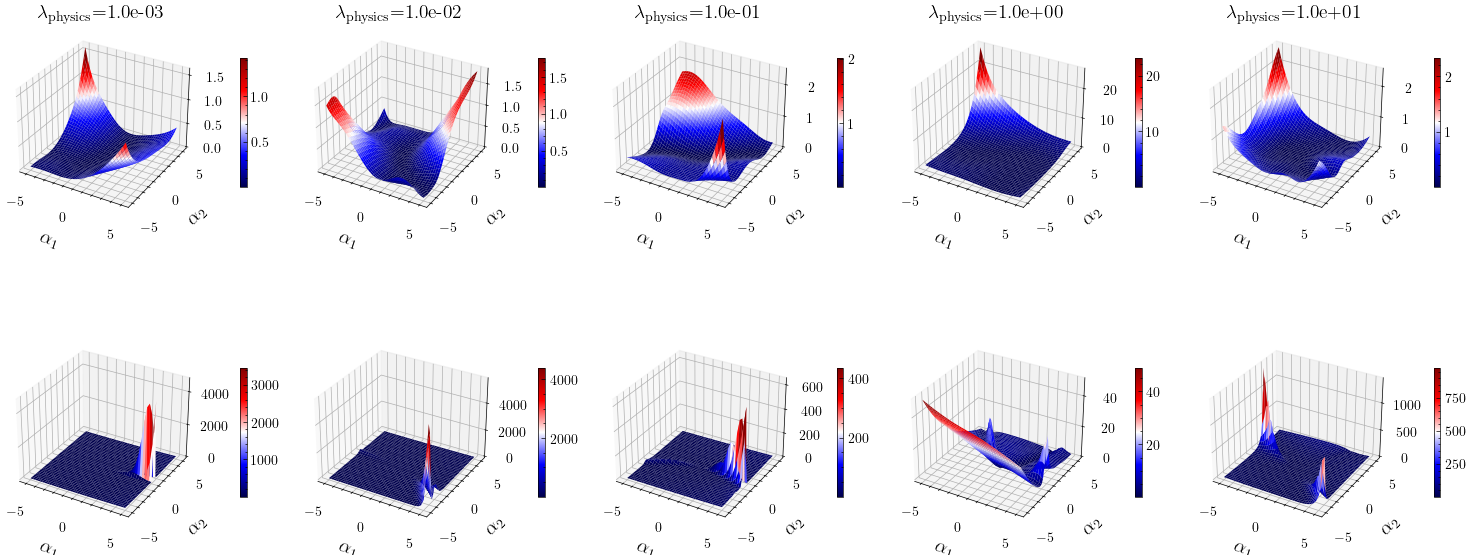

In [11]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(15, 12), subplot_kw={'projection': '3d'})

# Plot the random direction vector subspace projection of the loss landscape
for idx, param in enumerate(PARAM_LIST):
    surf_random = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_random[idx]),
        cmap=CMAP,
        linewidth=0,
        antialiased=True
    )
    
    fig.colorbar(surf_random, ax=ax[0, idx], shrink=0.15, orientation='vertical', pad=0.15)
    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    if TOP_PLOT:
        ax[0, idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.1e}", fontsize=14)

    # Plot the Hessian eigenvectors subspace projection of the loss landscape
    surf_hessian = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_hessian[idx]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )

    fig.colorbar(surf_hessian, ax=ax[1, idx], shrink=0.15, orientation='vertical', pad=0.15)
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=14)
    # ax[1, idx].set_zlim(vmin, vmax)

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

# Output the plots as PDF to the desired directory
loss_landscape_image_name = f"pinn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

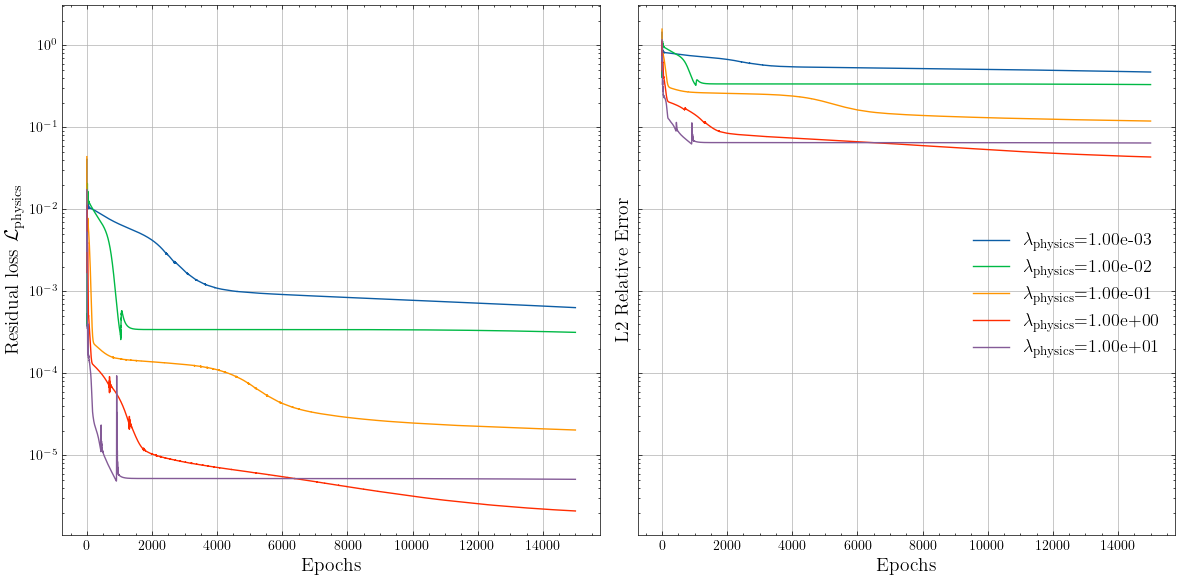

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the random direction vector subspace projection of the loss landscape
for residual_loss, param, l2_relative in zip(residual_losses_per_param, PARAM_LIST, test_losses_per_param_per_epoch):
    
    ax[0].semilogy(range(1, EPOCHS+1), residual_loss, label=f"{VARYING_PARAM_NOTATION}={param:.2e}")
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel(r"Residual loss $\mathcal{L}_{\mathrm{physics}}$", fontsize=14)
    # ax[0].legend(loc="best", fontsize=13)
    ax[0].grid()

    ax[1].semilogy(range(1, EPOCHS+1), l2_relative, label=f"{VARYING_PARAM_NOTATION}={param:.2e}")
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel("L2 Relative Error", fontsize=14)
    ax[1].legend(loc="best", fontsize=13, bbox_to_anchor=(1, 0.6))
    ax[1].grid()

plt.tight_layout()

# # Output the plots as PDF to the desired directory
# loss_landscape_image_name = f"pinn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

# if SAVE:
#     print("Saving...")
#     plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

[]

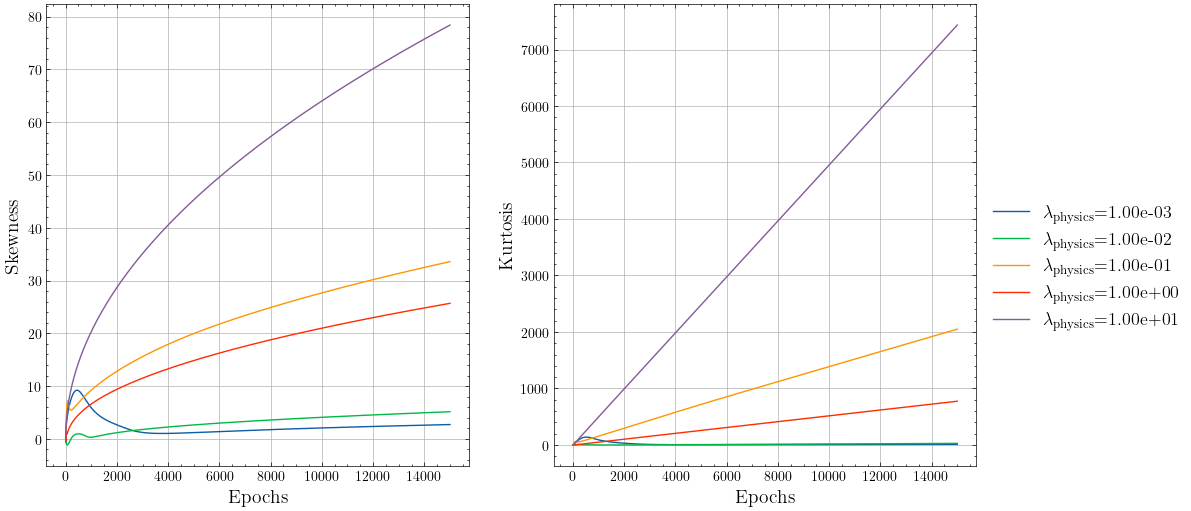

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for skewness, kurt, param in zip(skewness_per_param, kurtosis_per_param, PARAM_LIST): 
    ax[0].plot(range(1, EPOCHS+1), skewness, label=f"{VARYING_PARAM_NOTATION}={param:.2e}")
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel("Skewness", fontsize=14)
    ax[0].grid()

    ax[1].plot(range(1, EPOCHS+1), kurt, label=f"{VARYING_PARAM_NOTATION}={param:.2e}")
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel("Kurtosis", fontsize=14)
    ax[1].legend(loc="best", fontsize=13, bbox_to_anchor=(1, 0.6))
    ax[1].grid()

plt.plot()

Saving...


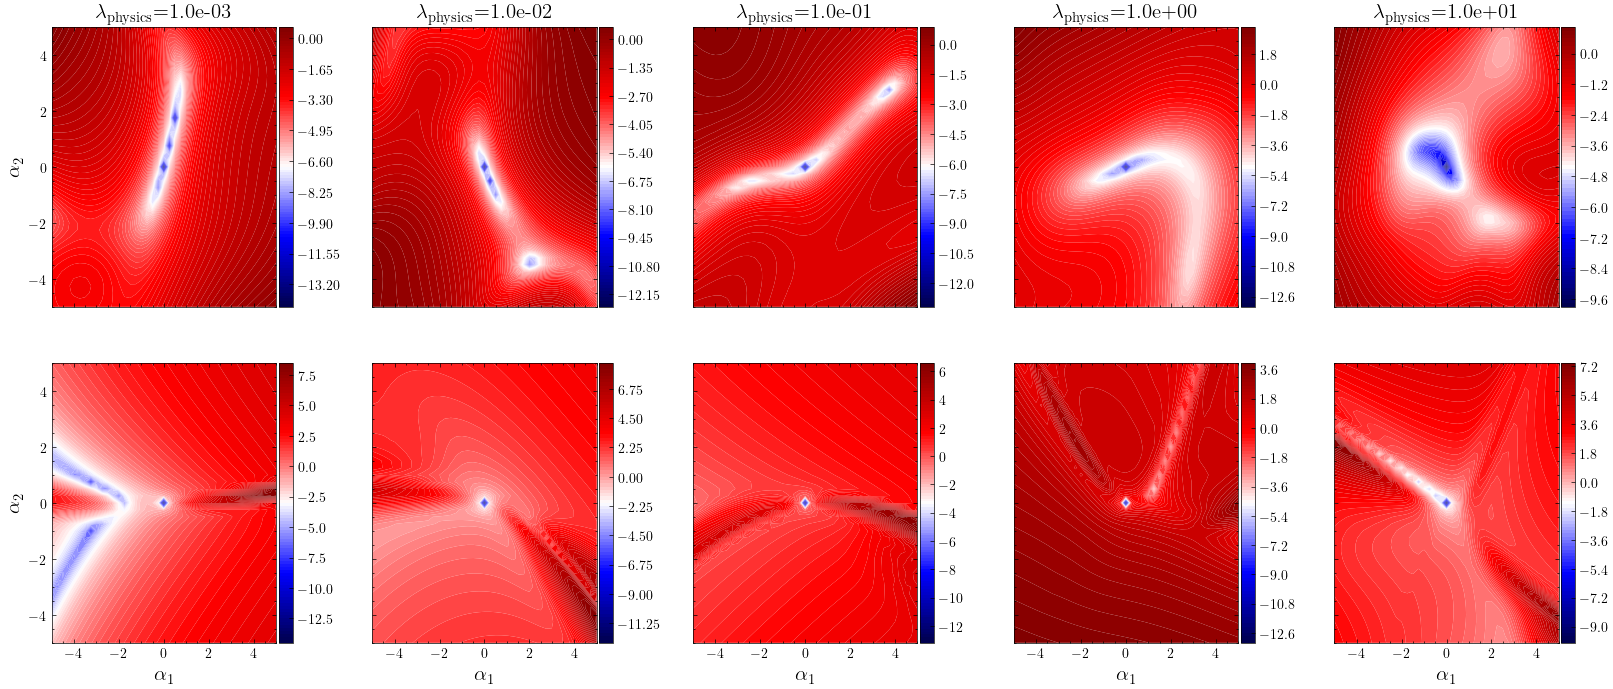

In [14]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

num_levels = 100
# levels = np.linspace(vmin, vmax, num_levels)

for index, (param) in enumerate(PARAM_LIST):
    contour_random = ax[0, index].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_random[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )
    fig.colorbar(contour_random, ax=ax[0, index], shrink=1, orientation='vertical', pad=0.01)

    
    if index == 0:
        ax[0, index].set_ylabel(r'$\alpha_2$', fontsize=15)
        ax[1, index].set_ylabel(r'$\alpha_2$', fontsize=15)

    if TOP_PLOT:
        ax[0, index].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.1e}", fontsize=15)


    contour_hessian = ax[1, index].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_hessian[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )
    fig.colorbar(contour_hessian, ax=ax[1, index], shrink=1, orientation='vertical', pad=0.01)
    
    ax[1, index].set_xlabel(r'$\alpha_1$', fontsize=15)

# Shared colorbar
# cbar = fig.colorbar(contours_pinn[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)

contour_image_name = f"pinn/{VARYING_PARAM}_contour_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_7243/3765407758.py:46: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_7243/3765407758.py:47: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


L2 absolute error: 1.65e+00
L2 relative error: 4.72e-01
L2 absolute error: 1.20e+00
L2 relative error: 3.32e-01
L2 absolute error: 3.71e-01
L2 relative error: 1.19e-01
L2 absolute error: 1.27e-01
L2 relative error: 4.35e-02
L2 absolute error: 1.92e-01
L2 relative error: 6.44e-02
Saving...


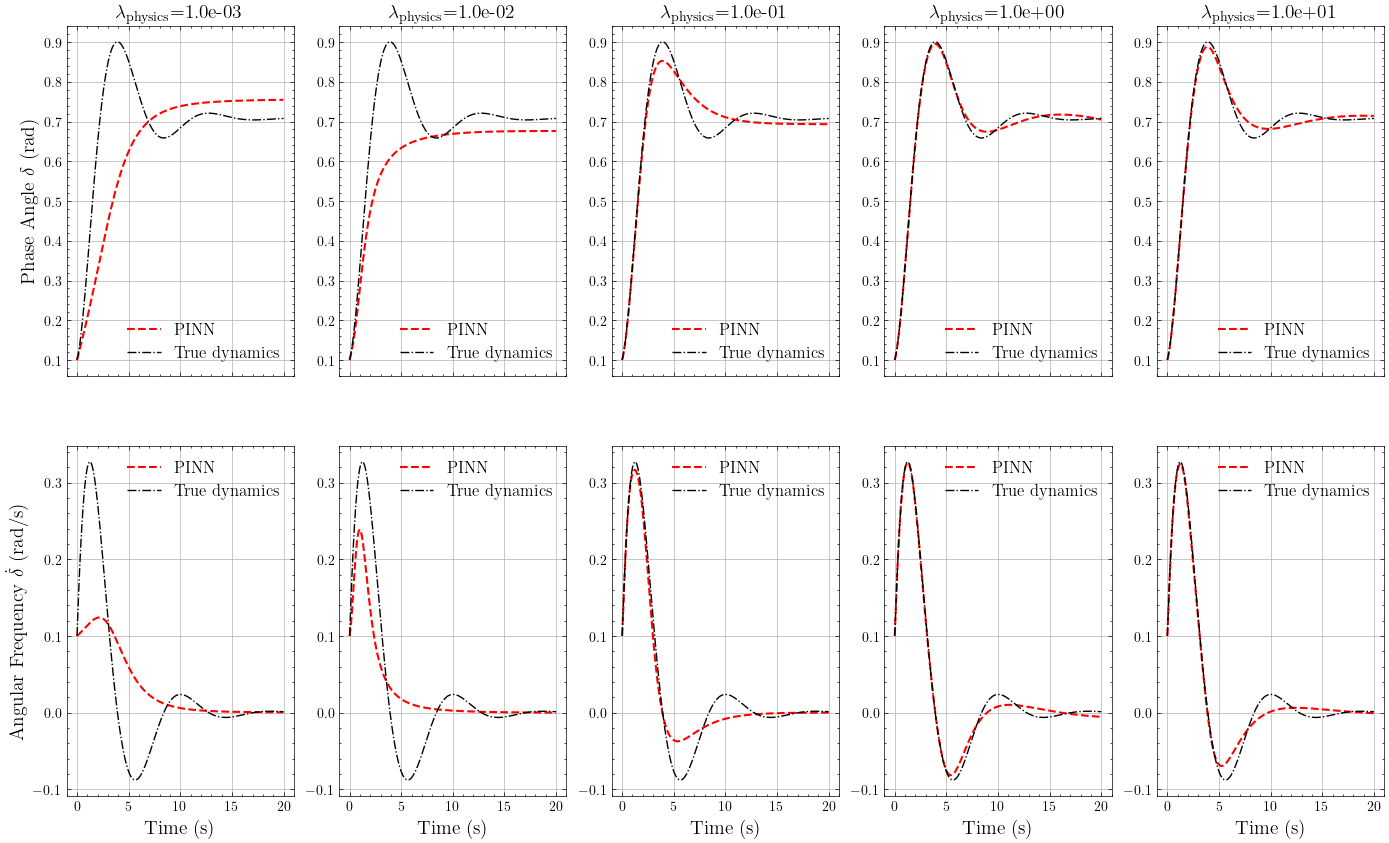

In [15]:
abs_errors_pinns = []
rel_errors_pinns = []

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, param in enumerate(PARAM_LIST):

    phase_angle_labels = numerical_solutions_exact_tensor[index, 0, :]

    angular_frequency_labels = numerical_solutions_exact_tensor[index, 1, :]

    phase_angle_pred = pinn_models[index].forward(data=times_tensor, initial_state=INITIAL_STATE)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=times_tensor,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    pred_vector = torch.stack(tensors=(phase_angle_pred, angular_frequency_pred), dim=0).squeeze()
    label_vector = torch.stack(tensors=(phase_angle_labels, angular_frequency_labels), dim=0)

    l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

    print(f"L2 absolute error: {l2_abs:.2e}")
    print(f"L2 relative error: {l2_rel:.2e}")

    abs_errors_pinns.append(l2_abs)
    rel_errors_pinns.append(l2_rel)

    ax[0, index].plot(times_tensor.detach().numpy(), phase_angle_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[0, index].plot(times_tensor.detach().numpy(), phase_angle_labels, color="black", linestyle="-.", label="True dynamics")
    ax[0, index].grid()
    ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.1e}", fontsize=14)

    ax[1, index].plot(times_tensor.detach().numpy(), angular_frequency_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[1, index].plot(times_tensor.detach().numpy(), angular_frequency_labels, color="black", linestyle="-.", label="True dynamics")
    ax[1, index].grid()
    ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)

exact_vs_pred_image: str = f"pinn/{VARYING_PARAM}_pinn_vs_ground_truth_seed_{SEED}.pdf"

# plt.subplots_adjust(left=0.1, right=0.9)
# plt.tight_layout()

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

Skewness=3.119390498944371
Kurtosis=9.305298132083056


/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_7243/756662244.py:66: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[0, idx].semilogy(dense_domain_set.detach().numpy(), residual_loss, 'o', marker='.')


Skewness=3.246426105885327
Kurtosis=11.276138413255907
Skewness=1.6804231406973966
Kurtosis=1.5834189333419184
Skewness=2.6433182871653225
Kurtosis=6.901768948224191
Skewness=2.773716831886532
Kurtosis=7.572527204917199


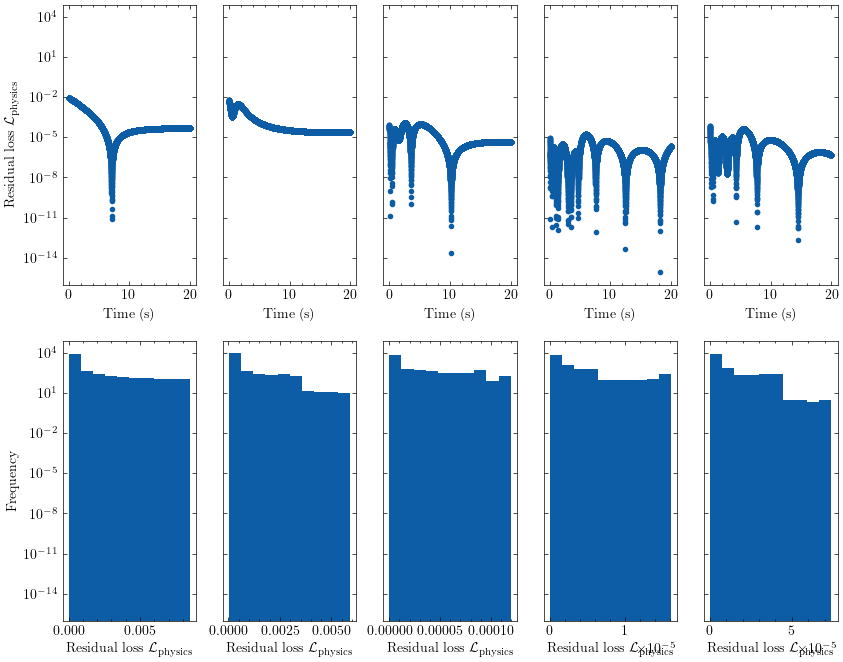

In [16]:
# Obtain collocation points sampled via LHS of size N_C
LHC = qmc.LatinHypercube(d=1)
dense_domain_set = LHC.random(n=N_C*10)
dense_domain_set = qmc.scale(
    dense_domain_set, T0, FINALTIME
).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

dense_domain_set: torch.tensor = torch.tensor(
    data=dense_domain_set[:, None].astype(np.float32), requires_grad=True
).to(device=DEVICE)


fig, axes = plt.subplots(2, len(PARAM_LIST), figsize=(10, 8), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    PHYSICS_WEIGHT: torch.Tensor = torch.tensor(data=[[param]])

    residual_loss = []

    for collocation_point in dense_domain_set:

        pinn = pinn_models[idx]

        phase_angle_pred = pinn.forward(data=collocation_point)

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=collocation_point,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        angular_acceleration_pred = torch.autograd.grad(
            outputs=angular_frequency_pred,
            inputs=collocation_point,
            grad_outputs=torch.ones_like(angular_frequency_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        swing_inputs = SwingEquationInputs(
            phase_angle=phase_angle_pred,
            angular_frequency=angular_frequency_pred,
            angular_acceleration=angular_acceleration_pred,
            inertia=INERTIA,
            damping=DAMPING,
            mechanical_power=MECHANICAL_POWER,
            voltage_magnitude=VOLTAGE,
            voltages=VOLTAGES,
            phase_angles=PHASE_ANGLES,
            susceptances=SUSCEPTANCES,
            controller_proportional=None,
            controller_integral=None,
        )

        residual = physics_based_loss(swing_inputs=swing_inputs, include_controllers=False)
        residual_loss.append(residual.item())

    skewness_val = skew(a=np.array(residual_loss))
    kurtosis_val = kurtosis(a=np.array(residual_loss), fisher=True)

    print(f"Skewness={skewness_val}\nKurtosis={kurtosis_val}")

    axes[0, idx].semilogy(dense_domain_set.detach().numpy(), residual_loss, 'o', marker='.')
    axes[0, idx].set_xlabel('Time (s)')

    if idx == 0:
        axes[0, idx].set_ylabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')
        axes[1, idx].set_ylabel("Frequency")

    axes[1, idx].hist(residual_loss, log=False)
    axes[1, idx].set_xlabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')

plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


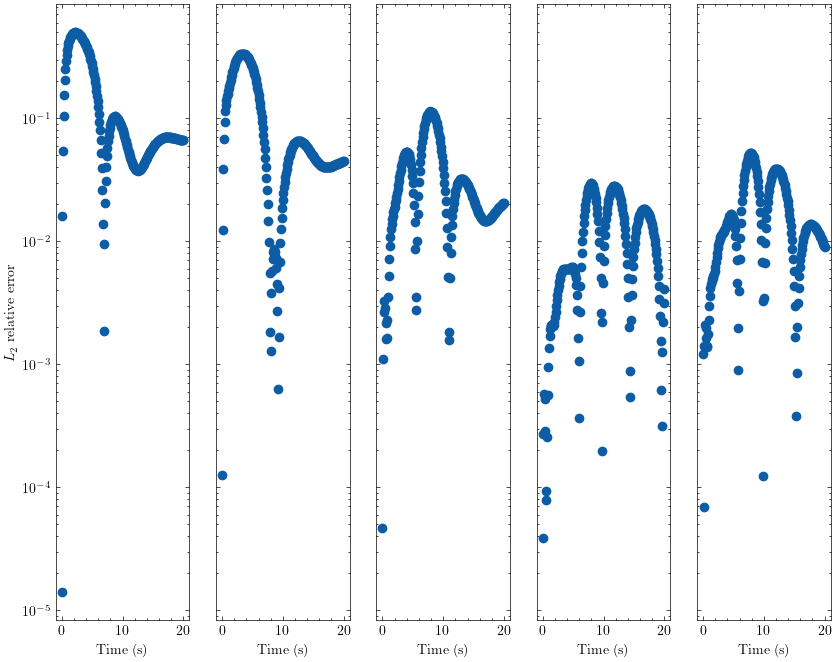

In [17]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(10, 8), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    test_performance = []

    for time_idx, time in enumerate(times_tensor):
        
        pinn = pinn_models[idx]

        ground_truth_phase_angle = numerical_solutions_exact_tensor[idx, 0, time_idx].view(1)

        phase_angle_pred = pinn.forward(data=time)

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=time,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        _, l2_rel = l2_error(pred=phase_angle_pred, ground_truth=ground_truth_phase_angle, dim=0)
        test_performance.append(l2_rel.item())

    print(type(numerical_domain))
    axes[idx].semilogy(numerical_domain, test_performance, 'o')
    axes[idx].set_xlabel('Time (s)')

    if idx == 0:
        axes[idx].set_ylabel(r"$L_2$ relative error")

plt.show()

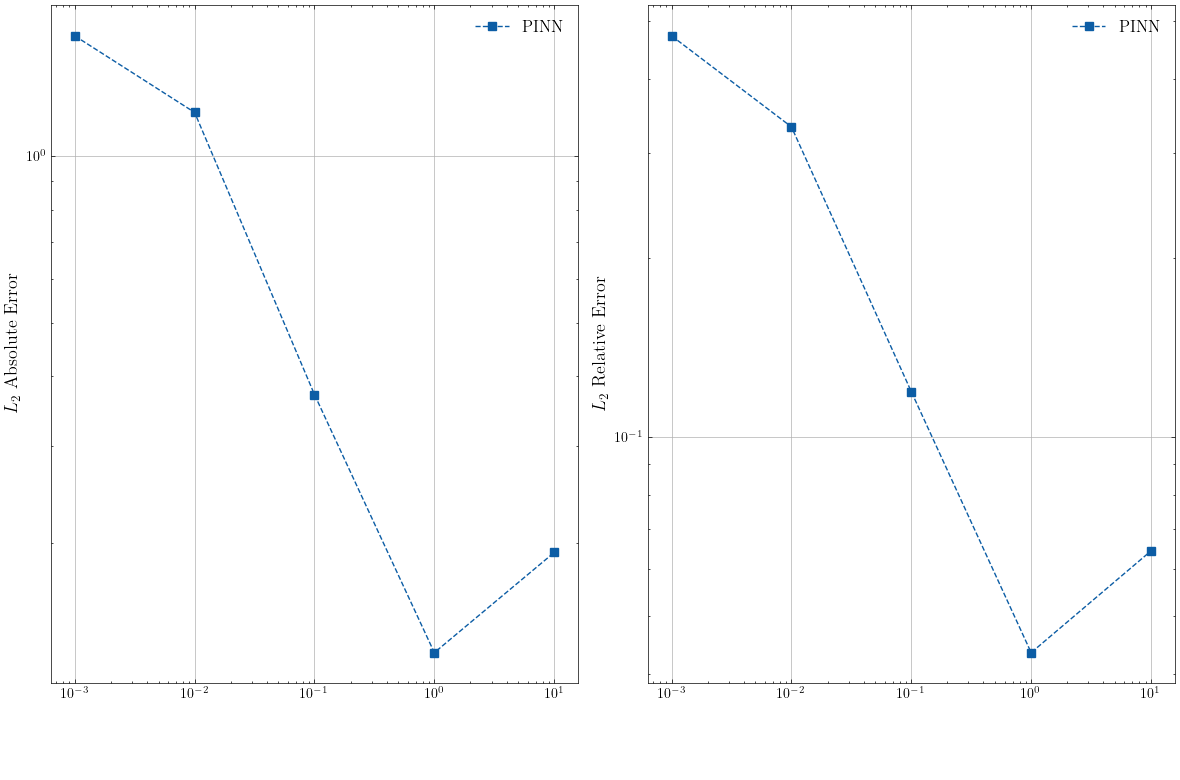

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].loglog(PARAM_LIST, [ls.detach().numpy() for ls in abs_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[0].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[0].set_ylabel("$L_{2}$ Absolute Error", fontsize=13)
ax[0].legend(fontsize=12)
ax[0].grid()

ax[1].loglog(PARAM_LIST, [ls.detach().numpy() for ls in rel_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[1].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[1].set_ylabel("$L_{2}$ Relative Error", fontsize=13)
# ax[1].set_xticklabels()
ax[1].legend(fontsize=12)
ax[1].grid()

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

test_error: str = f"{VARYING_PARAM}_l2_test_error_random_seed_{SEED}.pdf"

# if SAVE:
#     print("Saving...")
#     plt.savefig(fname=PATH_TO_IM_DIR+test_error, format="pdf", bbox_inches="tight")


<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_7243/1124365563.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("Training loss $\mathcal{L}_{\mathrm{PINN}}$ (log scale)", fontsize=12)


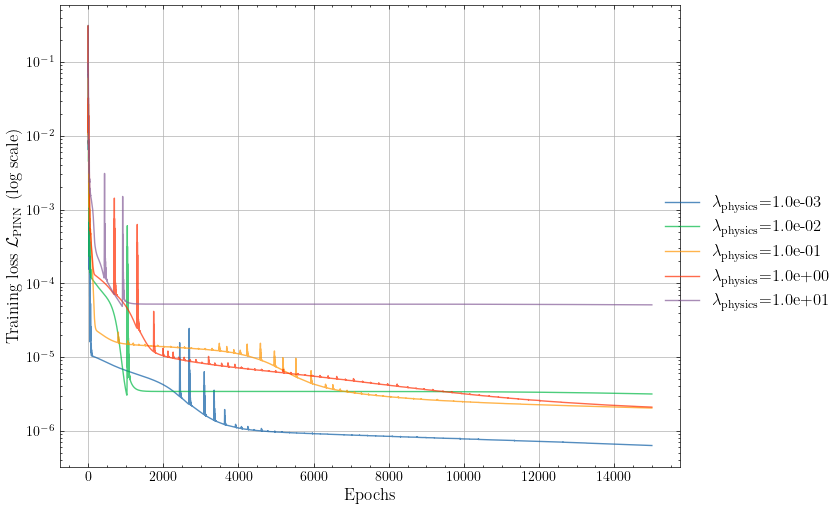

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for (param, training_loss) in zip(PARAM_LIST, training_losses_per_param):
    ax.semilogy(
        range(1, EPOCHS+1),
        training_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.1e}"
    )

ax.set_ylabel("Training loss $\mathcal{L}_{\mathrm{PINN}}$ (log scale)", fontsize=12)
ax.set_xlabel("Epochs", fontsize=12)
ax.grid()
ax.legend(loc="best", fontsize=12, bbox_to_anchor=(1.25, 0.6), borderaxespad=0.)

training_losses_plot = f"{VARYING_PARAM}_training_losses_seed_{SEED}.pdf"

# if SAVE:
#     plt.savefig(fname=PATH_TO_IM_DIR+training_losses_plot, format="pdf", bbox_inches="tight")

plt.show()

In [20]:
abs_errors_pinns_export = [err.item() for err in abs_errors_pinns]
rel_errors_pinns_export = [err.item() for err in rel_errors_pinns]

errors_output = f"pinn/l2_errors/abs_rel_errors_seed_{SEED}.npz"
np.savez(PATH_TO_IM_DIR+errors_output, absolute_errors=abs_errors_pinns_export, relative_errors=rel_errors_pinns_export)


In [21]:
training_loss_output = f"pinn/training_loss/training_loss_per_epoch_seed_{SEED}.npz"
np.savez(PATH_TO_IM_DIR+training_loss_output, training_loss=training_losses_per_param)